## Import Library

In [1]:
import pandas as pd
import numpy as np
import re
# import datetime as dt
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('Tr.csv')
df.drop(columns=['Index','Month &\nDate','Year','Month'],inplace=True)
df.head()

Date  # Of Covid Samples Received  # Of Covid Samples Billed  \
0  2020-03-31                            0                          0   
1  2020-04-30                            0                          0   
2  2020-05-31                            0                          0   
3  2020-06-30                         7890                        482   
4  2020-07-31                        34896                      24134   

   # Of Covid Samples Exception  # Of Covid Samples Client Bill  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             8                            2184   
4                             9                            4053   

   # Of Covid Samples Pending  # of Samples Received  # of samples Billed  \
0                           0                   3100                 2621   
1                           0                   1758                 1438   
2                           0                   2070                 1662   
3                        5216                   3242                 1382   
4                        6700                   3089                 3109   

   # of Samples Billed from Previous Month  AEL/Client Bill  ...  \
0                                      NaN              248  ...   
1                                    294.0              137  ...   
2                                    227.0              183  ...   
3                                    131.0              438  ...   
4                                   1263.0              476  ...   

   Total Credit Cards Processed amount  Lockbox Deposit Amount  \
0                                  NaN                     NaN   
1                                  NaN                     NaN   
2                                  NaN                     NaN   
3                                $0.00                   $0.00   
4                                $0.00                   $0.00   

  # of Denials Received  # of Denials Worked  # of Denials Pending  Denial %  \
0                    46                   46                     0     1.00%   
1                    74                   74                     0     4.00%   
2                    31                   31                     0     2.00%   
3                    80                   80                     0        7%   
4                   353                  353                     0       12%   

  # of Correspondence Received # of Correspondence Worked  \
0                            0                          0   
1                           12                         12   
2                           75                         75   
3                          146                        146   
4                         7195                       7195   

  # of Correspondence Pending Overall Samples Billed  
0                           0                   3454  
1                           0                   1692  
2                           0                   1954  
3                           0                   1862  
4                           0                  27237  

[5 rows x 32 columns]

In [4]:
## Data Cleaning
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('#_Of_', '')
df.columns=df.columns.str.replace('#_of_','')
df.columns

Index(['Date', 'Covid_Samples_Received', 'Covid_Samples_Billed',
       'Covid_Samples_Exception', 'Covid_Samples_Client_Bill',
       'Covid_Samples_Pending', 'Samples_Received', 'samples_Billed',
       'Samples_Billed_from_Previous_Month', 'AEL/Client_Bill', 'Exceptions',
       'samples_pending', 'Total_Charge_Entered', 'Claims_Submitted',
       'Claims_Accepted', 'Claims_Rejected', 'First_Pass_Acceptance_Rate',
       'Sum_of_Payment_Received', 'Sum_of_Payment_Posted',
       'Sum_of_Payment_Pending', 'Sum_of_Adjustment_Posted',
       'Payments_Received_in_the_Bank', 'Total_Credit_Cards_Processed_amount',
       'Lockbox_Deposit_Amount', 'Denials_Received', 'Denials_Worked',
       'Denials_Pending', 'Denial_%', 'Correspondence_Received',
       'Correspondence_Worked', 'Correspondence_Pending',
       'Overall_Samples_Billed'],
      dtype='object')

In [5]:
### Columns
# Numerical columns
num_cols=df.select_dtypes(include='number')
# Categorical columns
cat_cols=df.select_dtypes(include='object')

In [6]:
## Cleaning Columns Name
for i in cat_cols.columns.tolist()[1:]:
    df[i] = df[i].str.replace('$', '')
    df[i] = df[i].str.replace(',', '')
    df[i] = df[i].str.replace('%', '')
    df[i]=pd.to_numeric(df[i],errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 38 non-null     object 
 1   Covid_Samples_Received               38 non-null     int64  
 2   Covid_Samples_Billed                 38 non-null     int64  
 3   Covid_Samples_Exception              38 non-null     int64  
 4   Covid_Samples_Client_Bill            38 non-null     int64  
 5   Covid_Samples_Pending                38 non-null     int64  
 6   Samples_Received                     38 non-null     int64  
 7   samples_Billed                       38 non-null     int64  
 8   Samples_Billed_from_Previous_Month   37 non-null     float64
 9   AEL/Client_Bill                      38 non-null     int64  
 10  Exceptions                           38 non-null     int64  
 11  samples_pending                   

In [7]:
df['Date'].dtypes
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [8]:
df.head()

Covid_Samples_Received  Covid_Samples_Billed  \
Date                                                       
2020-03-31                       0                     0   
2020-04-30                       0                     0   
2020-05-31                       0                     0   
2020-06-30                    7890                   482   
2020-07-31                   34896                 24134   

            Covid_Samples_Exception  Covid_Samples_Client_Bill  \
Date                                                             
2020-03-31                        0                          0   
2020-04-30                        0                          0   
2020-05-31                        0                          0   
2020-06-30                        8                       2184   
2020-07-31                        9                       4053   

            Covid_Samples_Pending  Samples_Received  samples_Billed  \
Date                                                                  
2020-03-31                      0              3100            2621   
2020-04-30                      0              1758            1438   
2020-05-31                      0              2070            1662   
2020-06-30                   5216              3242            1382   
2020-07-31                   6700              3089            3109   

            Samples_Billed_from_Previous_Month  AEL/Client_Bill  Exceptions  \
Date                                                                          
2020-03-31                                 NaN              248          70   
2020-04-30                               294.0              137          52   
2020-05-31                               227.0              183         158   
2020-06-30                               131.0              438          16   
2020-07-31                              1263.0              476          20   

            ...  Total_Credit_Cards_Processed_amount  Lockbox_Deposit_Amount  \
Date        ...                                                                
2020-03-31  ...                                  NaN                     NaN   
2020-04-30  ...                                  NaN                     NaN   
2020-05-31  ...                                  NaN                     NaN   
2020-06-30  ...                                  0.0                     0.0   
2020-07-31  ...                                  0.0                     0.0   

            Denials_Received  Denials_Worked  Denials_Pending  Denial_%  \
Date                                                                      
2020-03-31                46              46                0       1.0   
2020-04-30                74              74                0       4.0   
2020-05-31                31              31                0       2.0   
2020-06-30                80              80                0       7.0   
2020-07-31               353             353                0      12.0   

            Correspondence_Received  Correspondence_Worked  \
Date                                                         
2020-03-31                        0                      0   
2020-04-30                       12                     12   
2020-05-31                       75                     75   
2020-06-30                      146                    146   
2020-07-31                     7195                   7195   

            Correspondence_Pending  Overall_Samples_Billed  
Date                                                        
2020-03-31                       0                    3454  
2020-04-30                       0                    1692  
2020-05-31                       0                    1954  
2020-06-30                       0                    1862  
2020-07-31                       0                   27237  

[5 rows x 31 columns]

In [9]:
### EDA
df.columns

Index(['Covid_Samples_Received', 'Covid_Samples_Billed',
       'Covid_Samples_Exception', 'Covid_Samples_Client_Bill',
       'Covid_Samples_Pending', 'Samples_Received', 'samples_Billed',
       'Samples_Billed_from_Previous_Month', 'AEL/Client_Bill', 'Exceptions',
       'samples_pending', 'Total_Charge_Entered', 'Claims_Submitted',
       'Claims_Accepted', 'Claims_Rejected', 'First_Pass_Acceptance_Rate',
       'Sum_of_Payment_Received', 'Sum_of_Payment_Posted',
       'Sum_of_Payment_Pending', 'Sum_of_Adjustment_Posted',
       'Payments_Received_in_the_Bank', 'Total_Credit_Cards_Processed_amount',
       'Lockbox_Deposit_Amount', 'Denials_Received', 'Denials_Worked',
       'Denials_Pending', 'Denial_%', 'Correspondence_Received',
       'Correspondence_Worked', 'Correspondence_Pending',
       'Overall_Samples_Billed'],
      dtype='object')

In [10]:
## Test Data is Stationary or not
# Adfuller Test
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [11]:
features=['Covid_Samples_Received','Sum_of_Payment_Received','Denials_Received','Denial_%']
### Train_test_split
df_data=df[features]
train_end=datetime(2021,12,31)
test_end=datetime(2023,4,30)
df_train=df[features][:train_end]
df_test=df[features][train_end+timedelta(days=1):test_end]
### Test the data is stationary or not
for i in features:
    print(adfuller_test(df_train[i],name=i))
    print('\n')

    Augmented Dickey-Fuller Test on "Covid_Samples_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1042
 No. Lags Chosen       = 9
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.2428. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
None


    Augmented Dickey-Fuller Test on "Sum_of_Payment_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.6923
 No. Lags Chosen       = 9
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.9897. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
None


    Augmented Dickey-Fuller Test on "Denials_Received" 
    ------------------------

In [12]:
denial=df_train['Denial_%']
df_train_1st_diff=df_train[['Covid_Samples_Received','Sum_of_Payment_Received','Denials_Received']].diff().dropna()
for i in df_train_1st_diff.columns:
    print(adfuller_test(df_train_1st_diff[i],name=i))
    print('\n')

    Augmented Dickey-Fuller Test on "Covid_Samples_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.6907
 No. Lags Chosen       = 8
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.8491. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
None


    Augmented Dickey-Fuller Test on "Sum_of_Payment_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.7422
 No. Lags Chosen       = 8
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
None


    Augmented Dickey-Fuller Test on "Denials_Received" 
    -----------------------------------------------

In [13]:
Sum_of_Payment_Received=df_train['Sum_of_Payment_Received']
Denials_Received=df_train['Denials_Received']
df_train_2nd_diff=df_train_1st_diff[['Covid_Samples_Received']].diff().dropna()
for i in df_train_2nd_diff.columns:
    print(adfuller_test(df_train_2nd_diff[i],name=i))
    print('\n')

    Augmented Dickey-Fuller Test on "Covid_Samples_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5617
 No. Lags Chosen       = 8
 Critical value 1%     = -4.223
 Critical value 5%     = -3.189
 Critical value 10%    = -2.73
 => P-Value = 0.8794. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
None




In [14]:
df_train_3rd_diff=df_train_2nd_diff.diff().dropna()
for i in df_train_3rd_diff.columns:
    print(adfuller_test(df_train_3rd_diff[i],name=i))
    print('\n')

    Augmented Dickey-Fuller Test on "Covid_Samples_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1175
 No. Lags Chosen       = 7
 Critical value 1%     = -4.223
 Critical value 5%     = -3.189
 Critical value 10%    = -2.73
 => P-Value = 0.2375. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
None




In [15]:
df_train_4th_diff=df_train_3rd_diff.diff().dropna()
for i in df_train_4th_diff.columns:
    print(adfuller_test(df_train_4th_diff[i],name=i))
    print('\n')

    Augmented Dickey-Fuller Test on "Covid_Samples_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7152
 No. Lags Chosen       = 7
 Critical value 1%     = -4.332
 Critical value 5%     = -3.233
 Critical value 10%    = -2.749
 => P-Value = 0.4233. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
None




In [16]:
df_train_5th_diff=df_train_4th_diff.diff().dropna()
for i in df_train_5th_diff.columns:
    print(adfuller_test(df_train_5th_diff[i],name=i))
    print('\n')

    Augmented Dickey-Fuller Test on "Covid_Samples_Received" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.706
 No. Lags Chosen       = 3
 Critical value 1%     = -4.069
 Critical value 5%     = -3.127
 Critical value 10%    = -2.702
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
None




## Denials_Received

In [17]:
## GRAY

### Using ARIMA

In [18]:
fig = px.line(df, y='Denials_Received')
fig.update_layout(
    title='Denials_Received',
    xaxis_title='Date',
    yaxis_title='No. of Samples',
    )
fig.show()

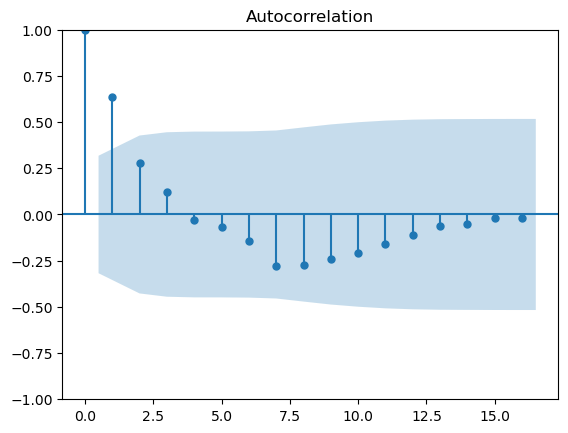

In [19]:
# Autocorrelation i.e q
acf = plot_acf(df_data['Denials_Received'])

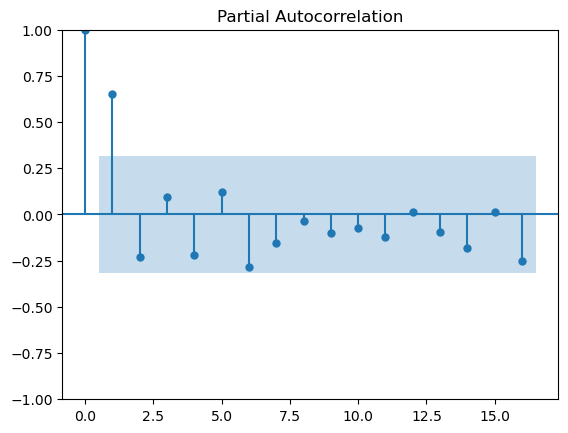

In [20]:
# PACF i.e p
pacf= plot_pacf(df_data['Denials_Received'])

In [21]:
model_ARIMA_DR=sm.tsa.ARIMA(df_train['Denials_Received'],order=(2,1,2))
model_Arima_fit_DR=model_ARIMA_DR.fit()
model_Arima_fit_DR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Denials_Received   No. Observations:                   22
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -178.859
Date:                Mon, 19 Jun 2023   AIC                            367.718
Time:                        19:19:23   BIC                            372.940
Sample:                    03-31-2020   HQIC                           368.851
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0066      0.960     -0.007      0.994      -1.889       1.876
ar.L2          0.3531      1.889      0.187      0.852      -3.350       4.056
ma.L1         -0.0008    104.701  -7.91e-06      1.000    -205.211     205.210
ma.L2         -0.9992      0.602     -1.660      0.097      -2.179       0.181
sigma2       1.25e+06   8.32e-05    1.5e+10      0.000    1.25e+06    1.25e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               219.29
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               8.94   Skew:                             3.83
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+28. Standard errors may be unstable.
"""

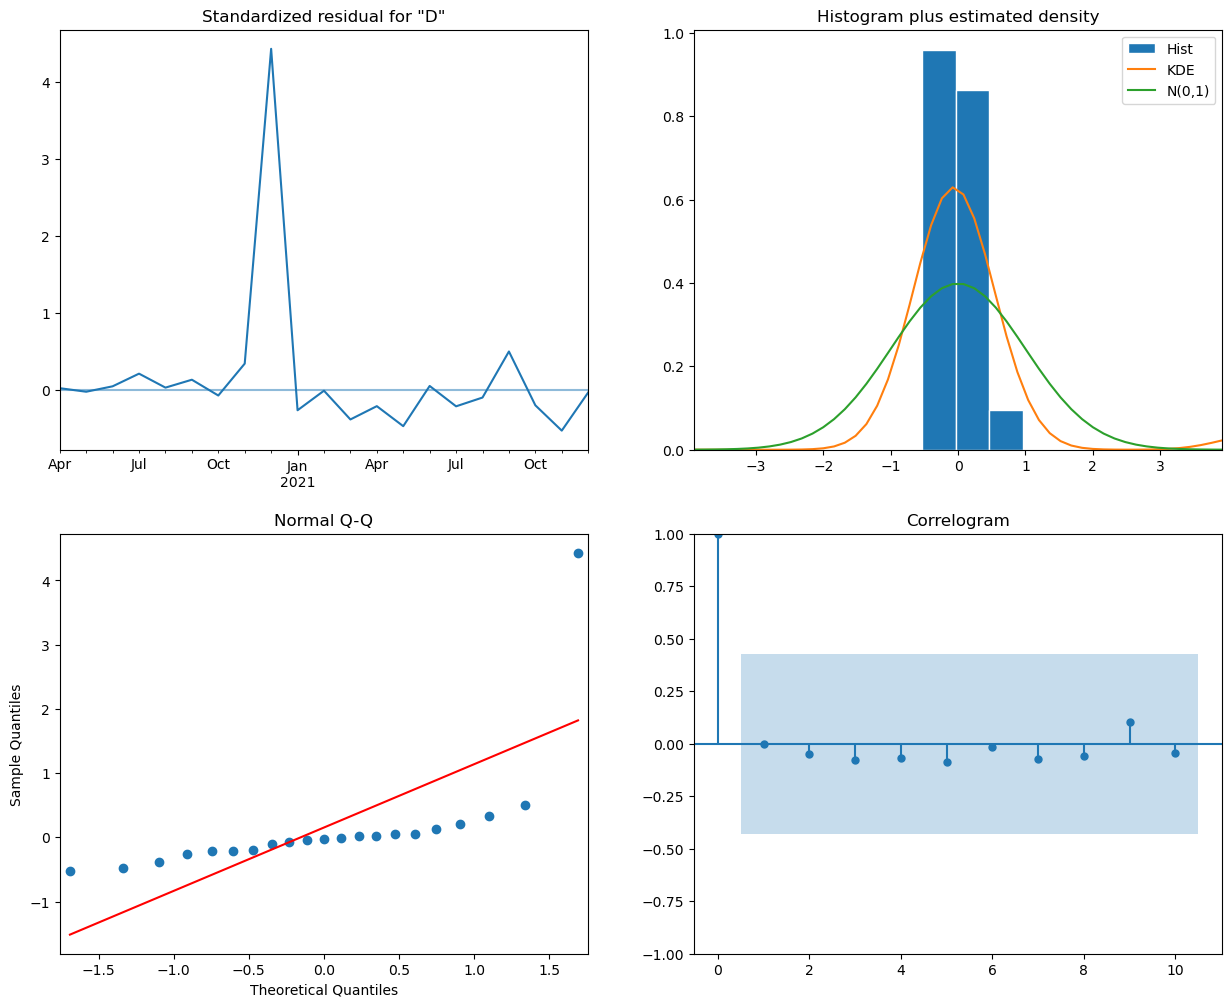

In [22]:
model_Arima_fit_DR.plot_diagnostics(figsize=(15,12))
plt.show()

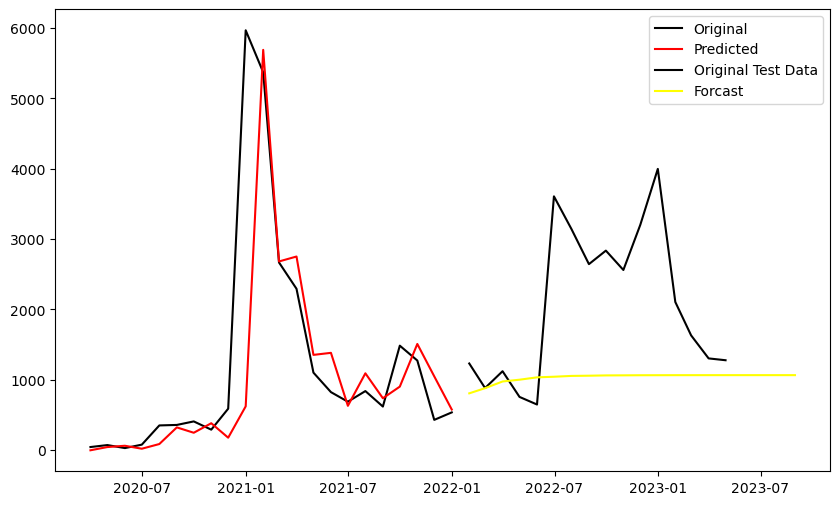

In [23]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Denials_Received'],label='Original',color='black')
plt.plot(model_Arima_fit_DR.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Denials_Received'],label='Original Test Data',color='black')

plt.plot(model_Arima_fit_DR.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [24]:
actual_value=df_test['Denials_Received']
predicted_value=model_Arima_fit_DR.forecast(steps=16)
def test_model(actual_value,predicted_value):
    mae=mean_absolute_error(actual_value,predicted_value)
    r2=r2_score(actual_value,predicted_value)
    rmse=np.sqrt(mean_squared_error(actual_value,predicted_value))
    print(f'MAE:{mae}\nR2:{r2}\nRMSE:{rmse}')
test_model(actual_value,predicted_value)

MAE:1114.1578446500755
R2:-0.9019840838176618
RMSE:1455.1319850939649


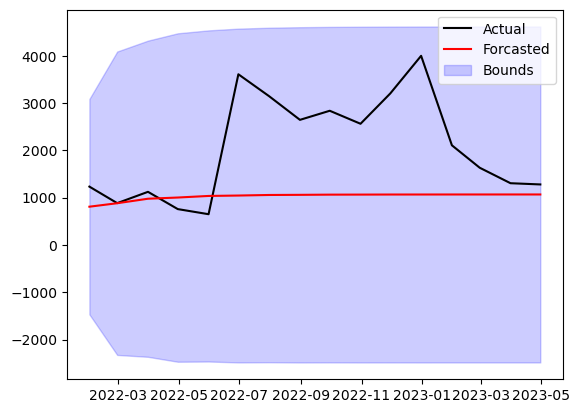

In [25]:
predicted_value_ul=model_Arima_fit_DR.get_forecast(steps=16)
upper_bound=predicted_value_ul.conf_int()[['lower Denials_Received']].values
lower_bound=predicted_value_ul.conf_int()[['upper Denials_Received']].values
upper_bound=np.ravel(upper_bound)
lower_bound=np.ravel(lower_bound)
x_values=df_test['Denials_Received'].keys().tolist()
plt.plot(df_test['Denials_Received'],color='black',label='Actual')
plt.plot(predicted_value,color='red',label='Forcasted')
plt.fill_between(x_values,lower_bound,upper_bound,color='blue',alpha=0.2,label='Bounds')
plt.legend()
plt.show()

In [128]:
with open('Arima_DR.pkl','wb') as f:
    pickle.dump(model_Arima_fit_DR,f)

In [142]:
data=model_Arima_fit_DR.predict(start=datetime(2024,6,30),end=datetime(2024,6,30),
                           params=model_Arima_fit_DR.params)
data=data[0]

In [144]:
data

1067.288128311191

### Auto Arima

In [26]:
model_auto_arima_DR=auto_arima(df_train['Denials_Received'],seasonal=False)
model_auto_arima_DR.fit(df_train['Denials_Received'])
model_auto_arima_DR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -188.829
Date:                Mon, 19 Jun 2023   AIC                            381.658
Time:                        19:19:55   BIC                            383.840
Sample:                    03-31-2020   HQIC                           382.172
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7354      0.175      4.212      0.000       0.393       1.078
sigma2      1.683e+06   2.01e+05      8.388      0.000    1.29e+06    2.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               171.66
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              12.21   Skew:                             3.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
actual_value=df_test['Denials_Received']
predicted_value=model_auto_arima_DR.predict(n_periods=16)
test_model(actual_value,predicted_value)

MAE:1967.2925310129556
R2:-3.5929551437055567
RMSE:2261.2316200478735


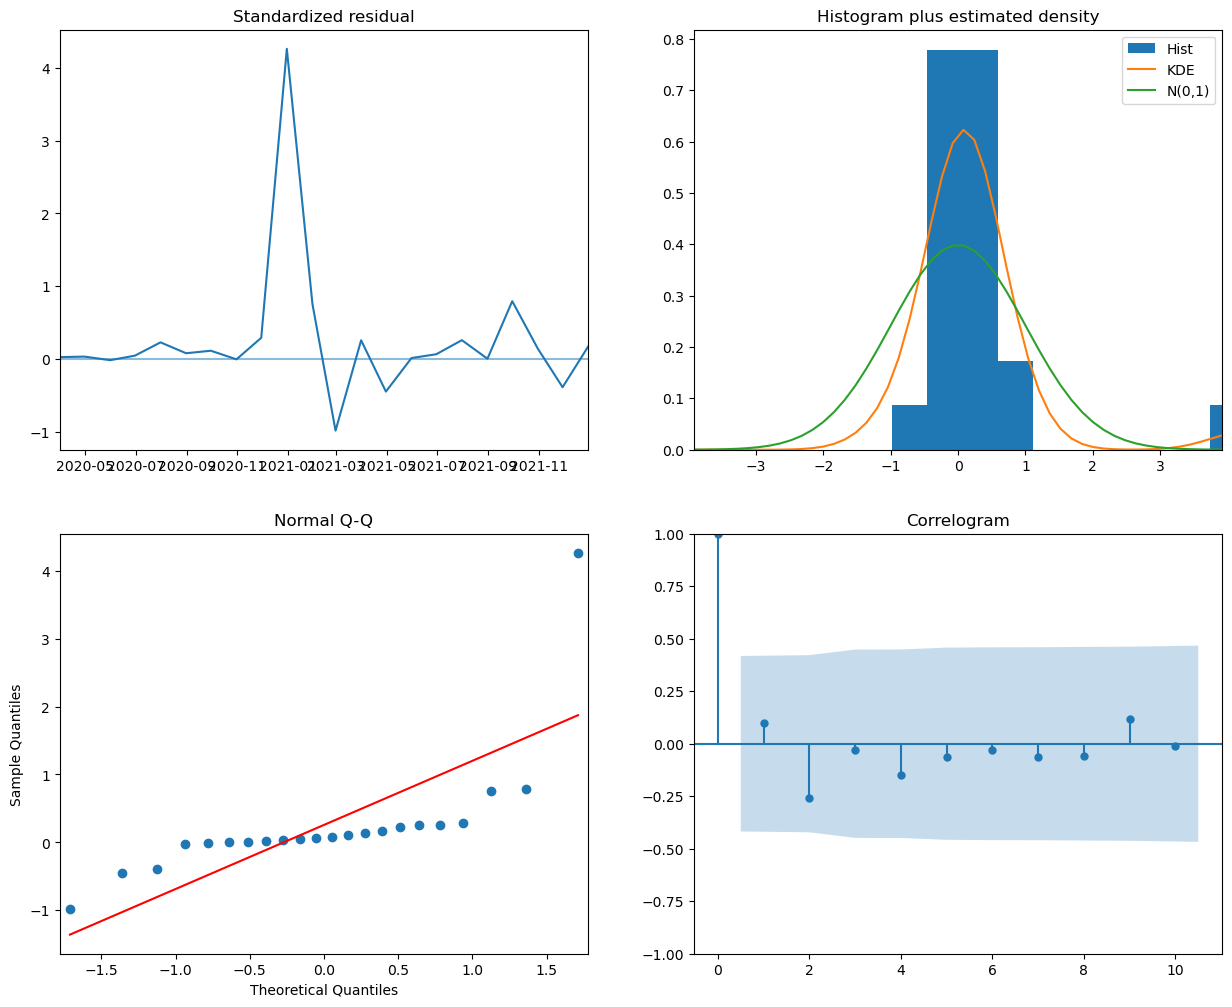

In [28]:
model_auto_arima_DR.plot_diagnostics(figsize=(15,12))
plt.show()

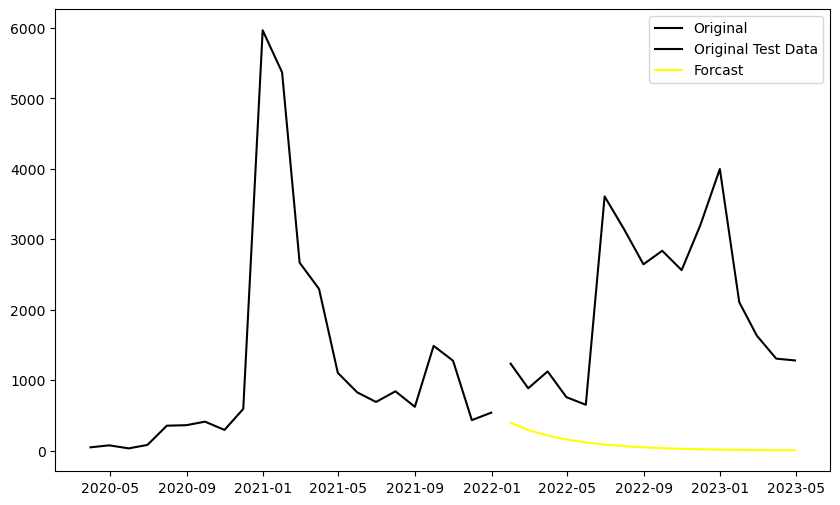

In [29]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Denials_Received'],label='Original',color='black')
# plt.plot(model_auto_arima_DR.predict(),label='Predicted',color='red')
plt.plot(df_test['Denials_Received'],label='Original Test Data',color='black')

plt.plot(model_auto_arima_DR.predict(n_periods=16),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [30]:
# forecast = model_fit.get_forecast(steps=num_steps, alpha=0.05)

# # Extract the upper and lower bounds from the prediction interval
# upper_bound = forecast.conf_int()[['upper_column_name']].values
# lower_bound = forecast.conf_int()[['lower_column_name']].values

# forcastt=model_auto_arima_DR.get_forecast(steps=16)
# forcastt.conf_int()


forecast, conf_int = model_auto_arima_DR.predict(n_periods=16,
                                   return_conf_int=True)
lower_bound=conf_int[:,0]
upper_bound=conf_int[:,1]

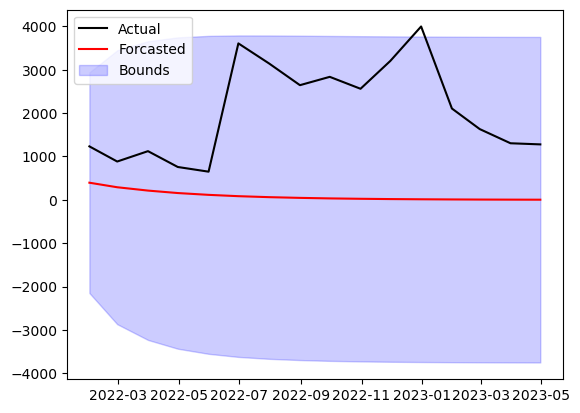

In [31]:
x_values=df_test['Denials_Received'].keys().tolist()
plt.plot(df_test['Denials_Received'],color='black',label='Actual')
plt.plot(forecast,color='red',label='Forcasted')
plt.fill_between(x_values,lower_bound,upper_bound,color='blue',alpha=0.2,label='Bounds')
plt.legend()
plt.show()

### Prophet

In [32]:
dr=pd.DataFrame(Denials_Received)
dr=dr.reset_index()
dr=dr.rename(columns={'Date':'ds','Denials_Received':'y'})
dr.head()

ds    y
0 2020-03-31   46
1 2020-04-30   74
2 2020-05-31   31
3 2020-06-30   80
4 2020-07-31  353

In [33]:
model_prophet=Prophet()
model_prophet.fit(dr)

19:20:00 - cmdstanpy - INFO - Chain [1] start processing
19:20:00 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future_dates = model_prophet.make_future_dataframe(periods=15,freq='M')  # Specify the number of future days to predict

In [35]:
forecast=model_prophet.predict(future_dates)

In [36]:
forecast

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2020-03-31   819.937210 -1207.242672  2825.224665   819.937210   
1  2020-04-30   854.888089 -1175.139069  2844.452186   854.888089   
2  2020-05-31   891.003997 -1057.604601  2996.413187   891.003997   
3  2020-06-30   925.954876 -1154.003873  2897.667206   925.954876   
4  2020-07-31   962.070784  -842.770573  3013.827592   962.070784   
5  2020-08-31   998.186692 -1059.801719  2976.868799   998.186692   
6  2020-09-30  1033.137571  -984.804421  3033.318270  1033.137571   
7  2020-10-31  1069.253479  -872.415579  3049.413268  1069.253479   
8  2020-11-30  1104.204358  -872.944573  3117.626816  1104.204358   
9  2020-12-31  1140.320266  -858.374512  3301.360568  1140.320266   
10 2021-01-31  1176.436174  -676.204239  3099.153148  1176.436174   
11 2021-02-28  1209.056994  -723.219483  3366.264391  1209.056994   
12 2021-03-31  1245.172902  -672.053737  3275.789929  1245.172902   
13 2021-04-30  1280.123781  -683.927777  3265.421638  1280.123781   
14 2021-05-31  1316.239690  -648.753483  3384.273067  1316.239690   
15 2021-06-30  1351.190569  -734.903711  3265.492432  1351.190569   
16 2021-07-31  1387.306477  -549.227521  3356.772372  1387.306477   
17 2021-08-31  1423.422385  -519.799152  3291.414847  1423.422385   
18 2021-09-30  1458.373264  -446.929619  3561.229846  1458.373264   
19 2021-10-31  1494.489172  -439.027924  3422.779213  1494.489172   
20 2021-11-30  1529.440051  -431.423967  3551.725605  1529.440051   
21 2021-12-31  1565.555959  -333.315956  3444.743312  1565.555959   
22 2022-01-31  1601.671868  -375.183069  3606.878722  1601.671866   
23 2022-02-28  1634.292688  -428.320505  3789.957544  1634.292681   
24 2022-03-31  1670.408596  -291.485146  3724.607609  1670.408584   
25 2022-04-30  1705.359475  -246.852900  3754.337715  1705.359456   
26 2022-05-31  1741.475383  -292.526334  3752.517723  1741.475357   
27 2022-06-30  1776.426262  -123.852634  3696.189100  1776.426228   
28 2022-07-31  1812.542171  -209.229393  3783.563427  1812.542127   
29 2022-08-31  1848.658079   -85.528581  3608.303114  1848.658025   
30 2022-09-30  1883.608958  -174.896072  3950.954894  1883.608893   
31 2022-10-31  1919.724866   -85.989459  3878.548572  1919.724790   
32 2022-11-30  1954.675745   -52.559228  3766.454232  1954.675659   
33 2022-12-31  1990.791653   115.097415  4013.260567  1990.791553   
34 2023-01-31  2026.907561    97.725494  4130.004650  2026.907446   
35 2023-02-28  2059.528382   244.486355  4104.346757  2059.528254   
36 2023-03-31  2095.644290   127.351710  4047.132370  2095.644146   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    819.937210             0.0                   0.0                   0.0   
1    854.888089             0.0                   0.0                   0.0   
2    891.003997             0.0                   0.0                   0.0   
3    925.954876             0.0                   0.0                   0.0   
4    962.070784             0.0                   0.0                   0.0   
5    998.186692             0.0                   0.0                   0.0   
6   1033.137571             0.0                   0.0                   0.0   
7   1069.253479             0.0                   0.0                   0.0   
8   1104.204358             0.0                   0.0                   0.0   
9   1140.320266             0.0                   0.0                   0.0   
10  1176.436174             0.0                   0.0                   0.0   
11  1209.056994             0.0                   0.0                   0.0   
12  1245.172902             0.0                   0.0                   0.0   
13  1280.123781             0.0                   0.0                   0.0   
14  1316.239690             0.0                   0.0                   0.0   
15  1351.190569             0.0                   0.0                   0.0   
16  1387.306477             0.0              

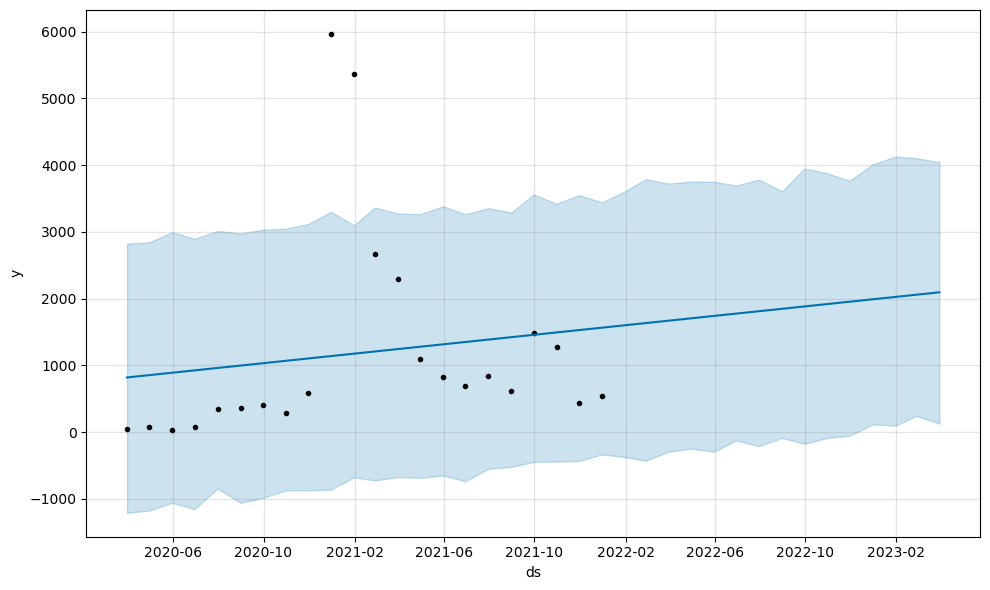

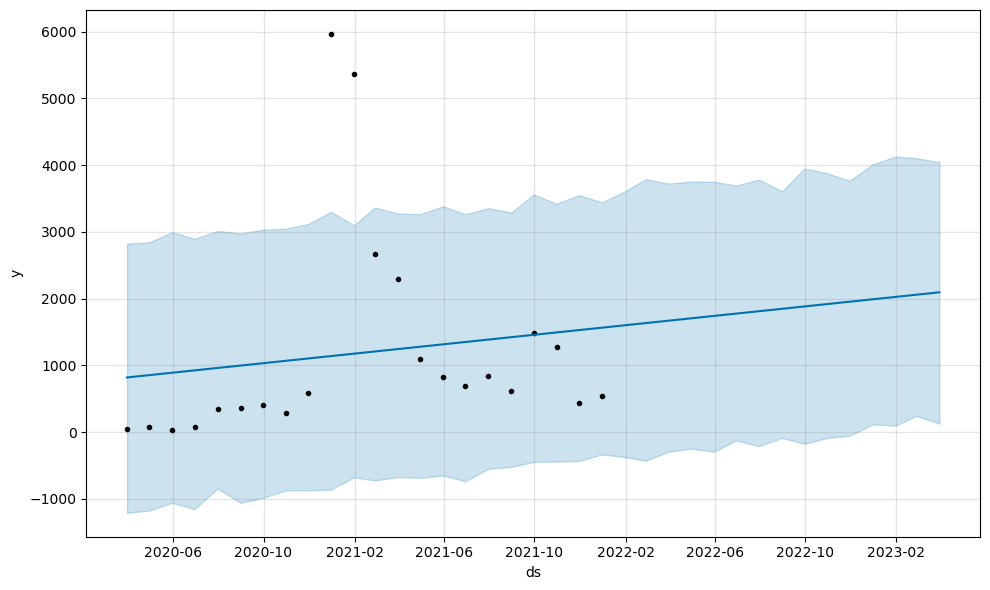

In [37]:
model_prophet.plot(forecast)

### SARIMAX

In [38]:
model = auto_arima(df_train['Denials_Received'], seasonal=True, m=12)
order = model.order
seasonal_order = model.seasonal_order
model = sm.tsa.SARIMAX(df_train['Denials_Received'], order=order, seasonal_order=seasonal_order)
fitted_model = model.fit()

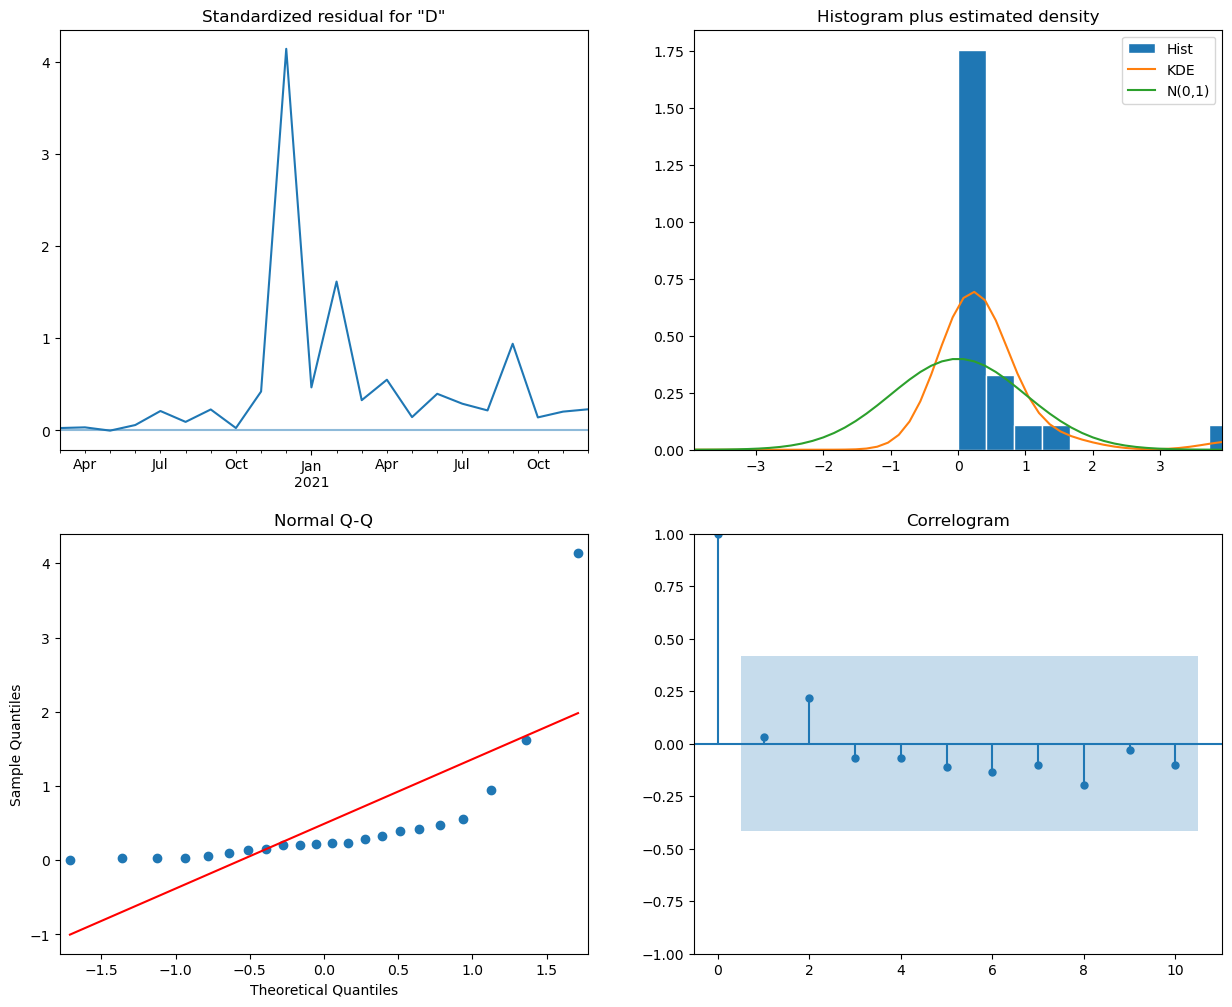

In [39]:
fitted_model.plot_diagnostics(figsize=(15,12))
plt.show()

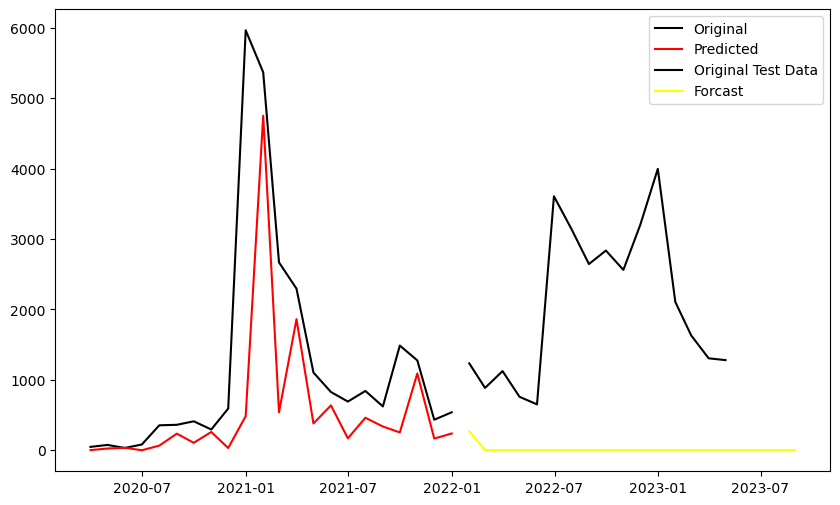

In [40]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Denials_Received'],label='Original',color='black')
plt.plot(fitted_model.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Denials_Received'],label='Original Test Data',color='black')

plt.plot(fitted_model.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [41]:
actual_value=df_test['Denials_Received']
predicted_value=fitted_model.forecast(steps=16)
test_model(actual_value,predicted_value)

MAE:2043.4268626766575
R2:-3.779215483574923
RMSE:2306.6263767084383


# Denial_%

### Arima

In [42]:
fig = px.line(df, y='Denial_%')
fig.update_layout(
    title='Denial_%',
    xaxis_title='Date',
    yaxis_title='No. of Samples',
    )
fig.show()

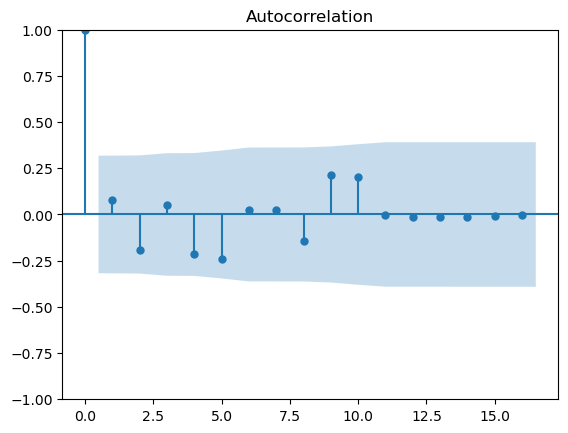

In [43]:
# Autocorrelation i.e q
acf = plot_acf(df_data['Denial_%'])

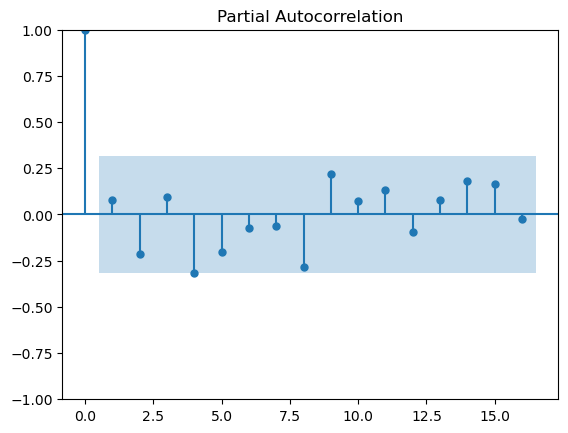

In [44]:
# PACF i.e p
pacf= plot_pacf(df_data['Denial_%'])

In [45]:
model_ARIMA_D=sm.tsa.ARIMA(df_train['Denial_%'],order=(1,0,1))
model_Arima_fit_D=model_ARIMA_D.fit()
model_Arima_fit_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Denial_%   No. Observations:                   22
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -65.243
Date:                Mon, 19 Jun 2023   AIC                            138.487
Time:                        19:21:02   BIC                            142.851
Sample:                    03-31-2020   HQIC                           139.515
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2238      0.454     15.908      0.000       6.334       8.114
ar.L1          0.6059      0.429      1.412      0.158      -0.235       1.447
ma.L1         -0.9997    116.885     -0.009      0.993    -230.091     228.092
sigma2        20.2712   2367.846      0.009      0.993   -4620.622    4661.165
===================================================================================
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):                10.73
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             1.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

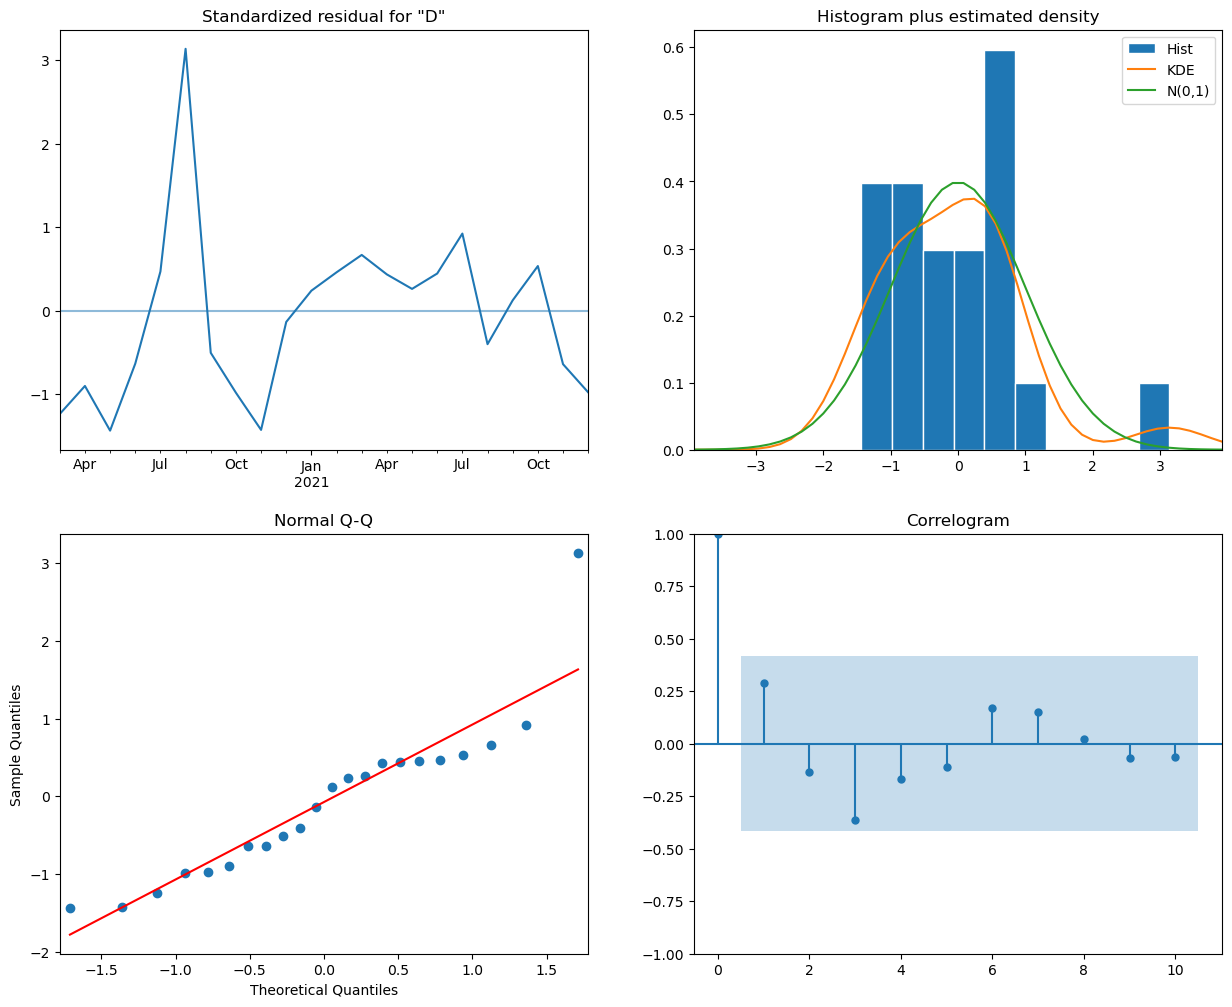

In [46]:
model_Arima_fit_D.plot_diagnostics(figsize=(15,12))
plt.show()

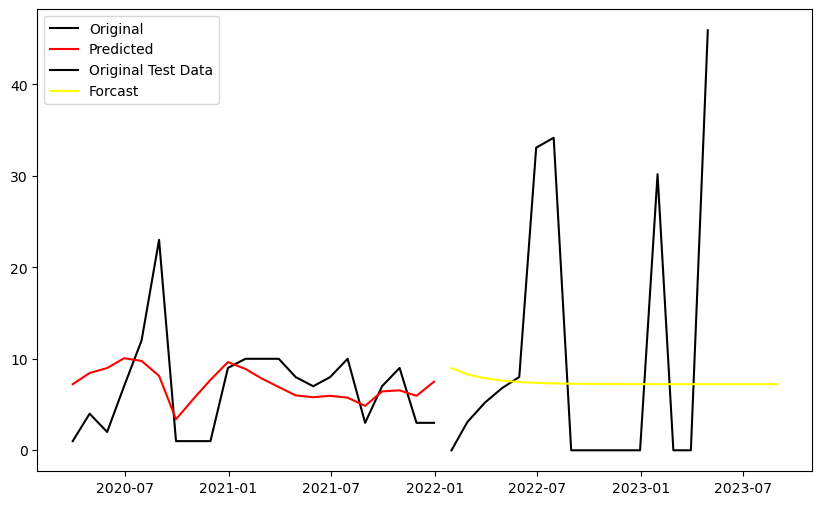

In [47]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Denial_%'],label='Original',color='black')
plt.plot(model_Arima_fit_D.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Denial_%'],label='Original Test Data',color='black')

plt.plot(model_Arima_fit_D.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [48]:
actual_value=df_test['Denial_%']
predicted_value=model_Arima_fit_D.forecast(steps=16)
test_model(actual_value,predicted_value)

MAE:11.447710434655272
R2:-0.05213310118830794
RMSE:15.589659352345445


In [57]:
# Extract the model Denail%
with open('Arima_D.pkl','wb') as f:
    pickle.dump(model_Arima_fit_D,f)

In [59]:
data=model_Arima_fit_D.predict(start=datetime(2024,6,30),end=datetime(2024,6,30))
data=data[0]

In [60]:
data

7.223782357790663

### Auto Arima

In [49]:
model_auto_arima_D=auto_arima(df_train['Denial_%'],seasonal=False)
model_auto_arima_D.fit(df_train['Denial_%'])
model_auto_arima_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -66.661
Date:                Mon, 19 Jun 2023   AIC                            137.323
Time:                        19:21:16   BIC                            139.505
Sample:                    03-31-2020   HQIC                           137.837
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7727      1.334      5.078      0.000       4.158       9.387
sigma2        25.0847      6.295      3.985      0.000      12.746      37.423
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                11.68
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             1.27
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
actual_value=df_test['Denial_%']
predicted_value=model_auto_arima_D.predict(n_periods=16)
test_model(actual_value,predicted_value)

MAE:11.057897727272728
R2:-0.05693878272621289
RMSE:15.62522214552828


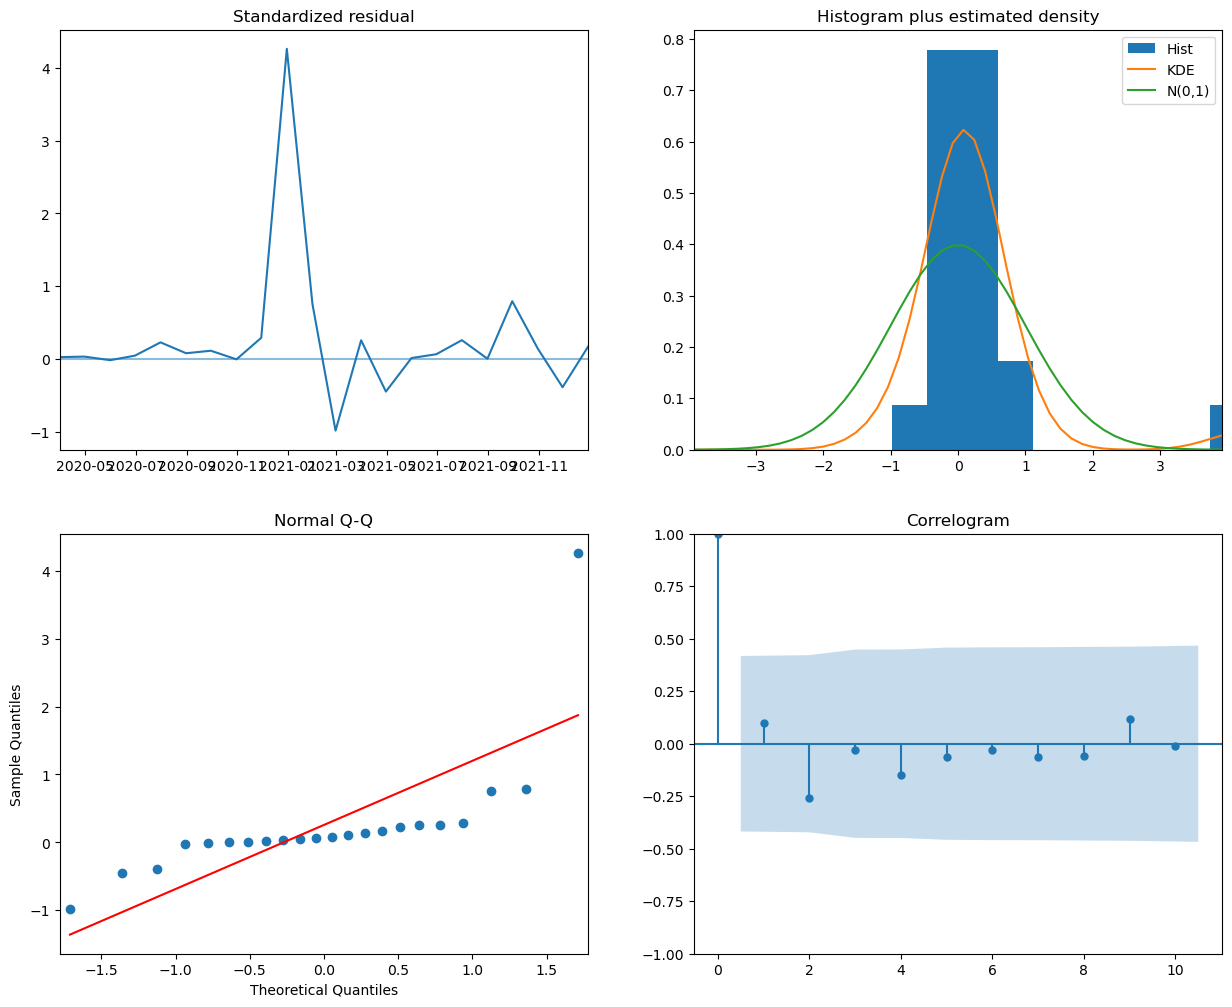

In [51]:
model_auto_arima_DR.plot_diagnostics(figsize=(15,12))
plt.show()

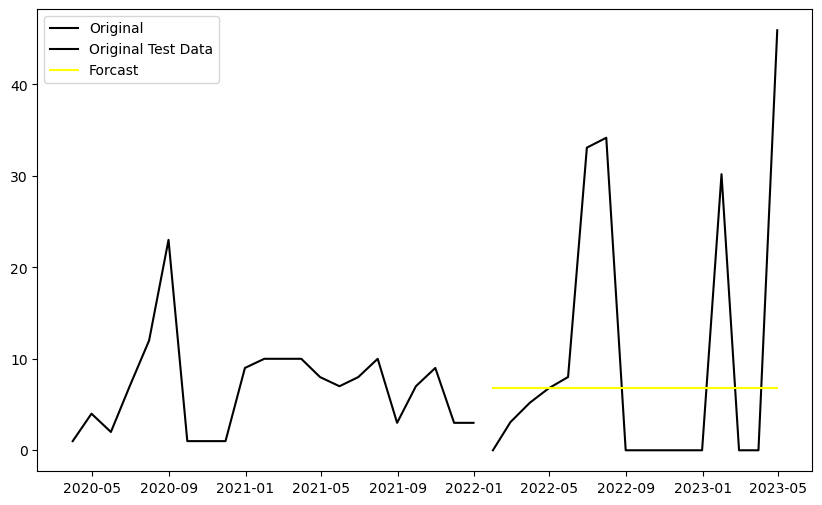

In [52]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Denial_%'],label='Original',color='black')
# plt.plot(model_auto_arima_DR.predict(),label='Predicted',color='red')
plt.plot(df_test['Denial_%'],label='Original Test Data',color='black')
plt.plot(model_auto_arima_D.predict(n_periods=16),label='Forcast',color='yellow')
plt.legend()
plt.show()

### Softmax

In [53]:
model = auto_arima(df_train['Denial_%'], seasonal=True, m=12)
order = model.order
seasonal_order = model.seasonal_order
model = sm.tsa.SARIMAX(df_train['Denial_%'], order=order, seasonal_order=seasonal_order)
fitted_model = model.fit()

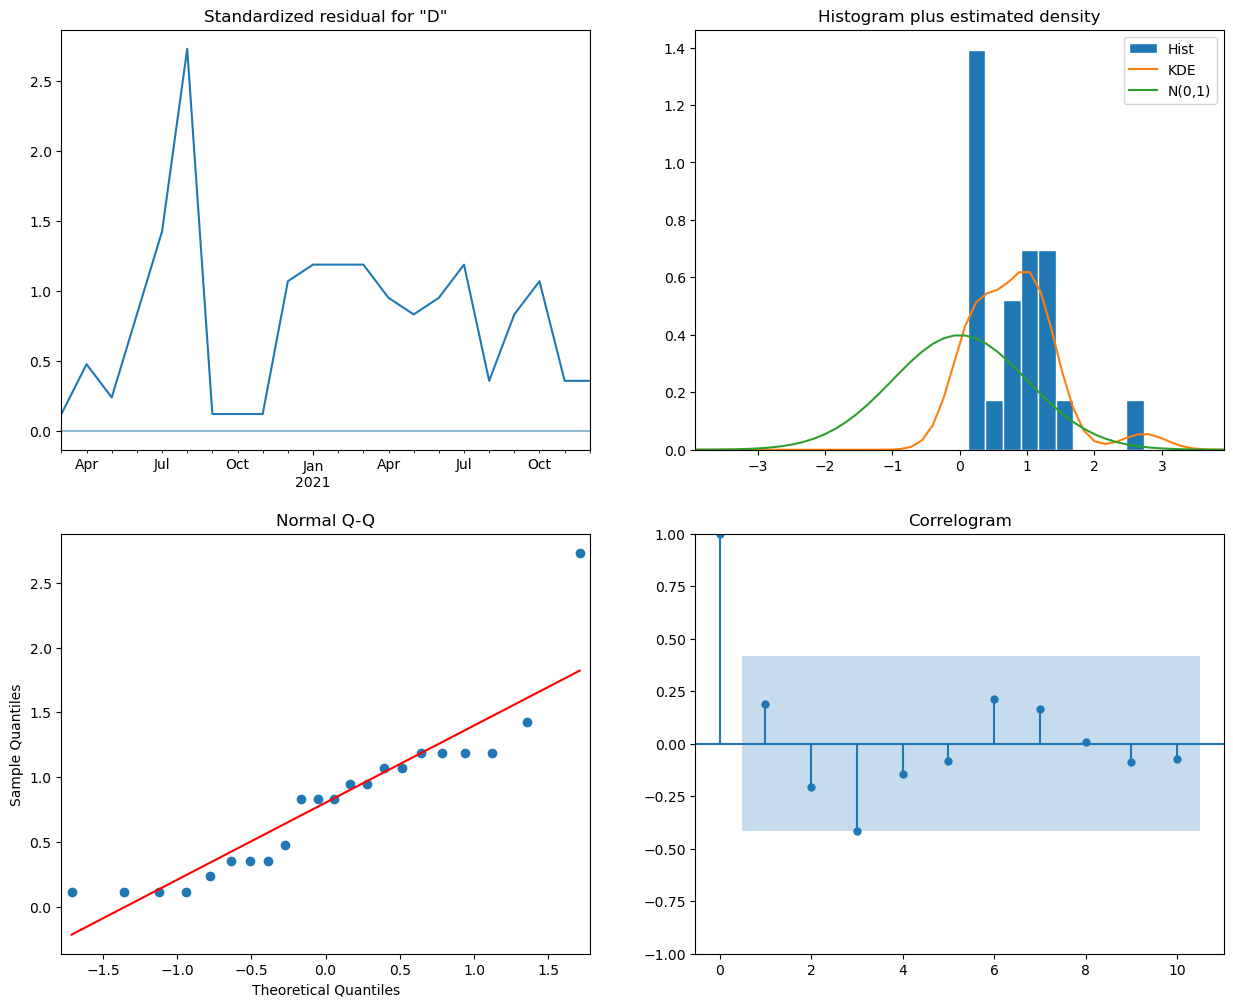

In [54]:
fitted_model.plot_diagnostics(figsize=(15,12))
plt.show()

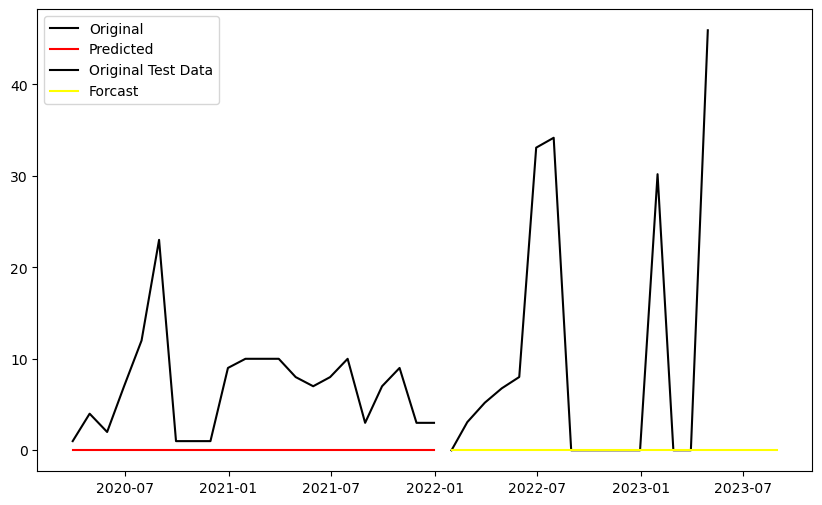

In [55]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Denial_%'],label='Original',color='black')
plt.plot(fitted_model.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Denial_%'],label='Original Test Data',color='black')

plt.plot(fitted_model.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [62]:
actual_value=df_test['Denial_%']
predicted_value=fitted_model.forecast(steps=16)
test_model(actual_value,predicted_value)

MAE:10.399375
R2:-0.46817898006288483
RMSE:18.41580825676679


## Sum_of_Payment_Received

### Sum of Payment Received

In [64]:
fig = px.line(df, y='Sum_of_Payment_Received')
fig.update_layout(
    title='Sum of Payment Received',
    xaxis_title='Date',
    yaxis_title='No. of Samples',
    )
fig.show()

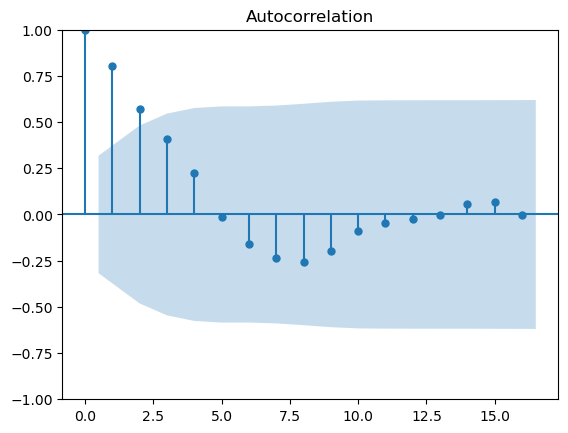

In [65]:
# Autocorrelation i.e q
acf = plot_acf(df_data['Sum_of_Payment_Received'])

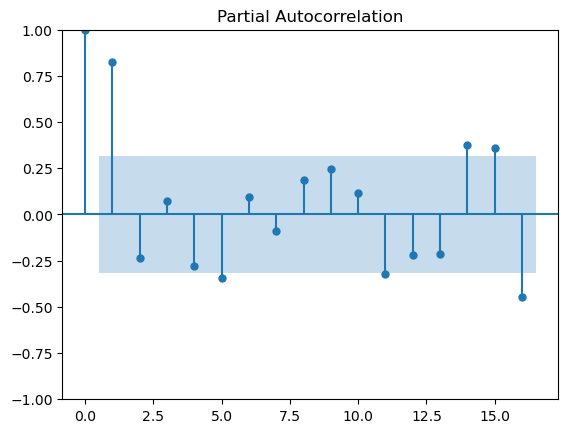

In [66]:
# PACF i.e p
pacf= plot_pacf(df_data['Sum_of_Payment_Received'])

In [108]:
model_ARIMA_SPR=sm.tsa.ARIMA(df_train['Sum_of_Payment_Received'],order=(2,1,2))
model_Arima_fit_SPR=model_ARIMA_SPR.fit()
model_Arima_fit_SPR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Sum_of_Payment_Received   No. Observations:                   22
Model:                      ARIMA(2, 1, 2)   Log Likelihood                -321.564
Date:                     Mon, 19 Jun 2023   AIC                            653.127
Time:                             19:47:48   BIC                            658.350
Sample:                         03-31-2020   HQIC                           654.261
                              - 12-31-2021                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8230      2.083     -0.395      0.693      -4.905       3.259
ar.L2         -0.7478      0.417     -1.794      0.073      -1.565       0.069
ma.L1          1.0678      2.245      0.476      0.634      -3.333       5.468
ma.L2          0.8140      1.280      0.636      0.525      -1.695       3.323
sigma2      1.287e+12   8.46e-12   1.52e+23      0.000    1.29e+12    1.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                18.69
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -1.33
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+39. Standard errors may be unstable.
"""

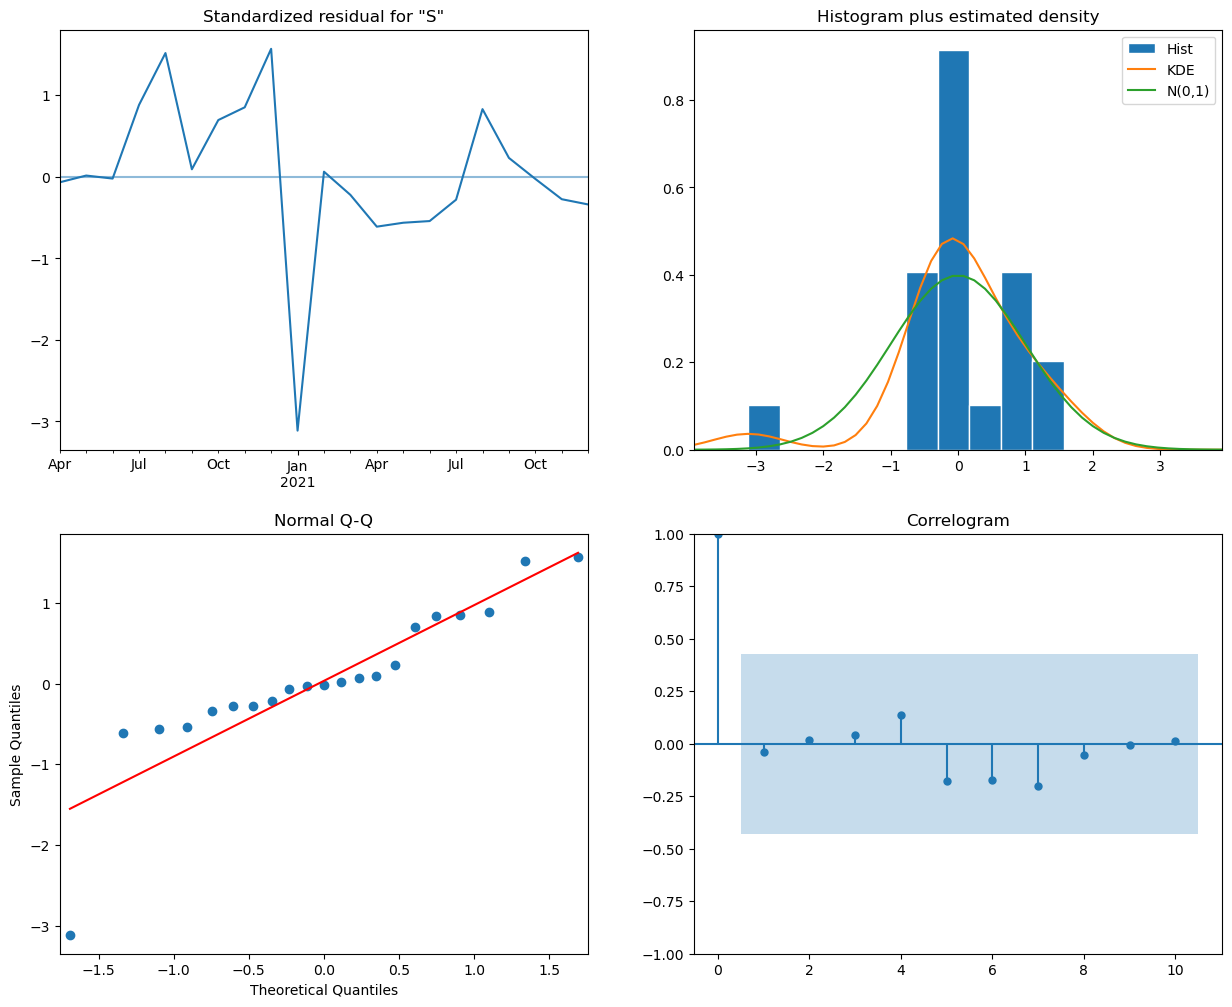

In [109]:
model_Arima_fit_SPR.plot_diagnostics(figsize=(15,12))
plt.show()

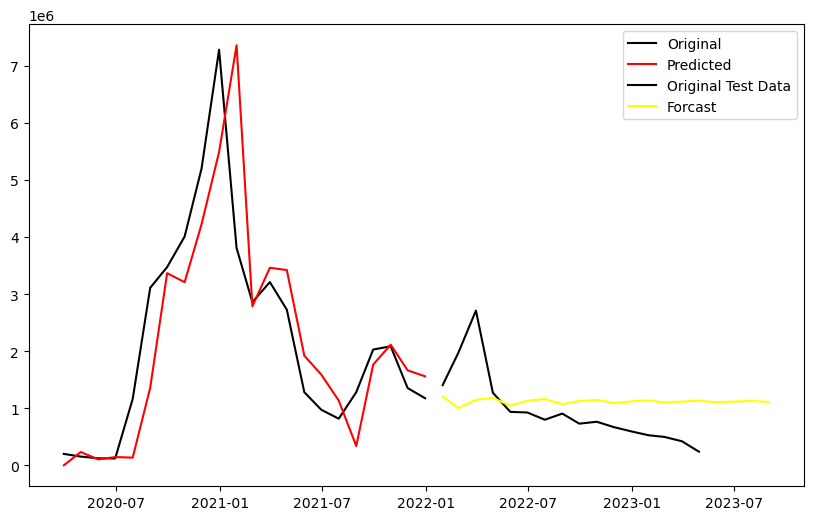

In [110]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Sum_of_Payment_Received'],label='Original',color='black')
plt.plot(model_Arima_fit_SPR.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Sum_of_Payment_Received'],label='Original Test Data',color='black')

plt.plot(model_Arima_fit_SPR.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [111]:
actual_value=df_test['Sum_of_Payment_Received']
predicted_value=model_Arima_fit_SPR.forecast(steps=16)
def test_model(actual_value,predicted_value):
    mae=mean_absolute_error(actual_value,predicted_value)
    r2=r2_score(actual_value,predicted_value)
    rmse=np.sqrt(mean_squared_error(actual_value,predicted_value))
    print(f'MAE:{mae}\nR2:{r2}\nRMSE:{rmse}')
test_model(actual_value,predicted_value)

MAE:512429.0018743442
R2:-0.08142657481918936
RMSE:634265.5525799998


In [120]:
# Extract the model Denail%
with open('Arima_SPR.pkl','wb') as f:
    pickle.dump(model_Arima_fit_SPR,f)

In [121]:
data=model_Arima_fit_SPR.predict(start=datetime(2024,6,30),end=datetime(2024,6,30))
data=data[0]

In [122]:
data

1117044.6053766583

### Auto Arima

In [112]:
model_auto_arima_SPR=auto_arima(df_train['Sum_of_Payment_Received'],seasonal=False)
model_auto_arima_SPR.fit(df_train['Sum_of_Payment_Received'])
model_auto_arima_SPR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -338.271
Date:                Mon, 19 Jun 2023   AIC                            680.541
Time:                        19:48:03   BIC                            682.724
Sample:                    03-31-2020   HQIC                           681.055
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8921      0.049     18.237      0.000       0.796       0.988
sigma2      1.284e+12   4.87e-16   2.64e+27      0.000    1.28e+12    1.28e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.54   Prob(JB):                         0.36
Heteroskedasticity (H):               0.25   Skew:                            -0.29
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [113]:
actual_value=df_test['Sum_of_Payment_Received']
predicted_value=model_auto_arima_DR.predict(n_periods=16)
test_model(actual_value,predicted_value)

MAE:960499.2881560129
R2:-2.479701772459153
RMSE:1137741.5496292748


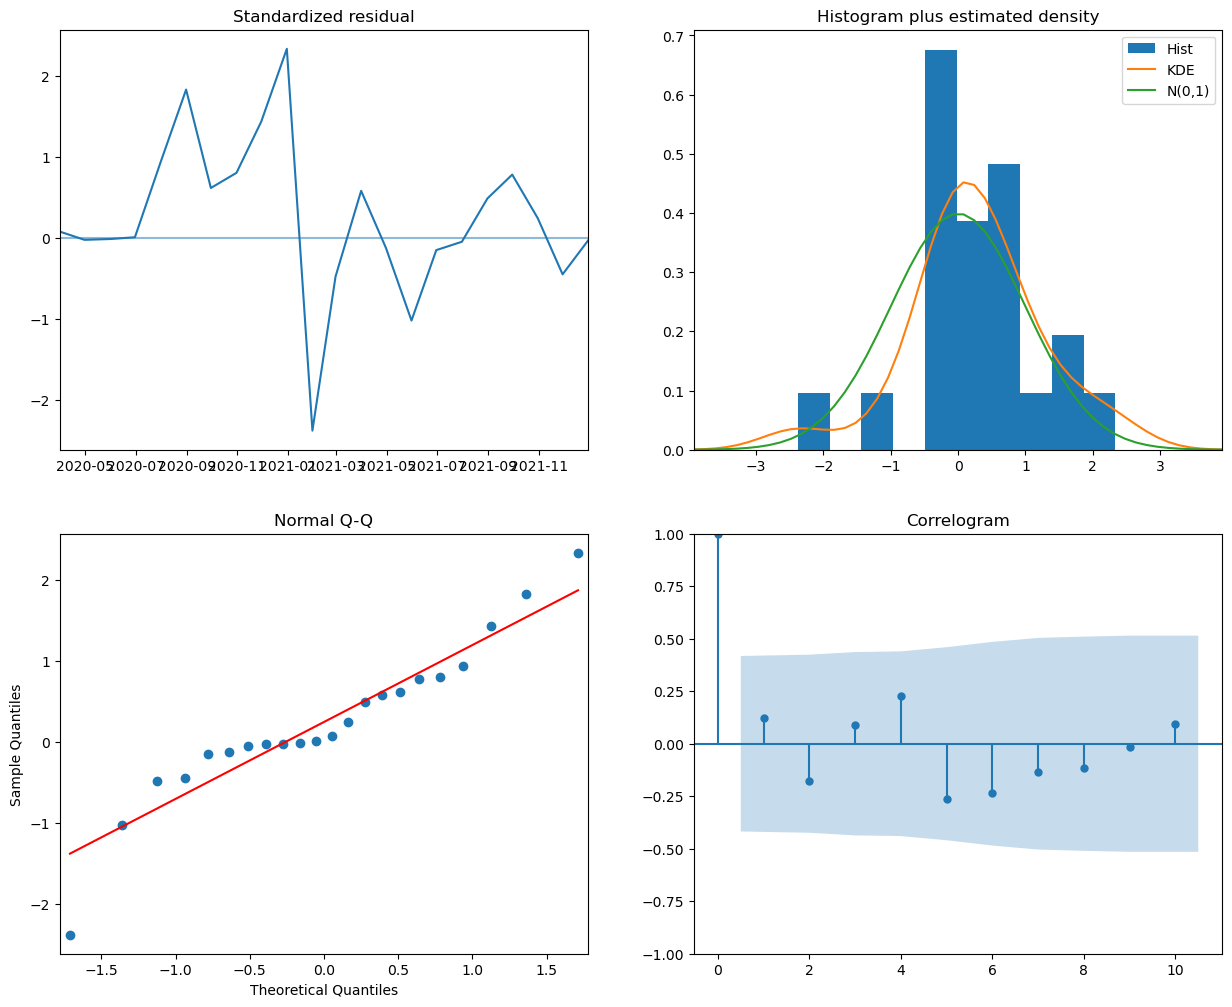

In [114]:
model_auto_arima_SPR.plot_diagnostics(figsize=(15,12))
plt.show()

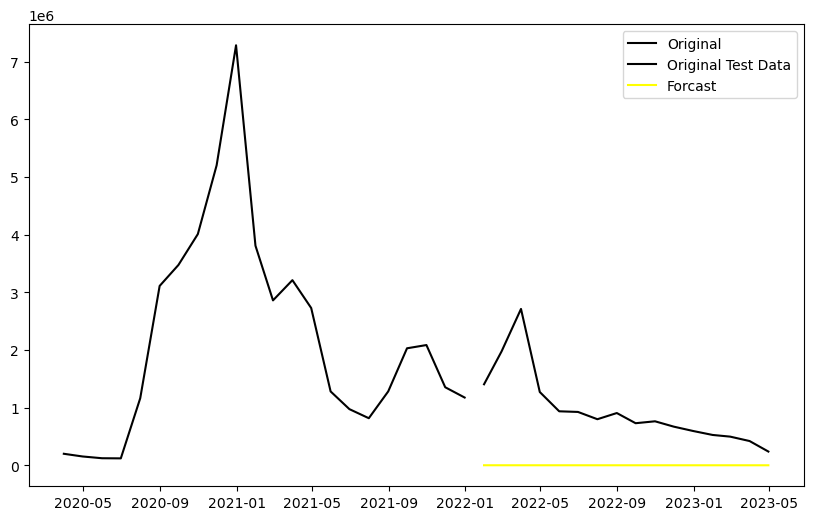

In [115]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Sum_of_Payment_Received'],label='Original',color='black')
# plt.plot(model_auto_arima_DR.predict(),label='Predicted',color='red')
plt.plot(df_test['Sum_of_Payment_Received'],label='Original Test Data',color='black')

plt.plot(model_auto_arima_DR.predict(n_periods=16),label='Forcast',color='yellow')
plt.legend()
plt.show()

### SARIMAX

In [116]:
model_SPR = auto_arima(df_train['Sum_of_Payment_Received'], seasonal=True, m=12)
order = model_SPR.order
seasonal_order = model_SPR.seasonal_order
model_SPR = sm.tsa.SARIMAX(df_train['Sum_of_Payment_Received'], order=order, seasonal_order=seasonal_order)
fitted_model_SPR = model_SPR.fit()

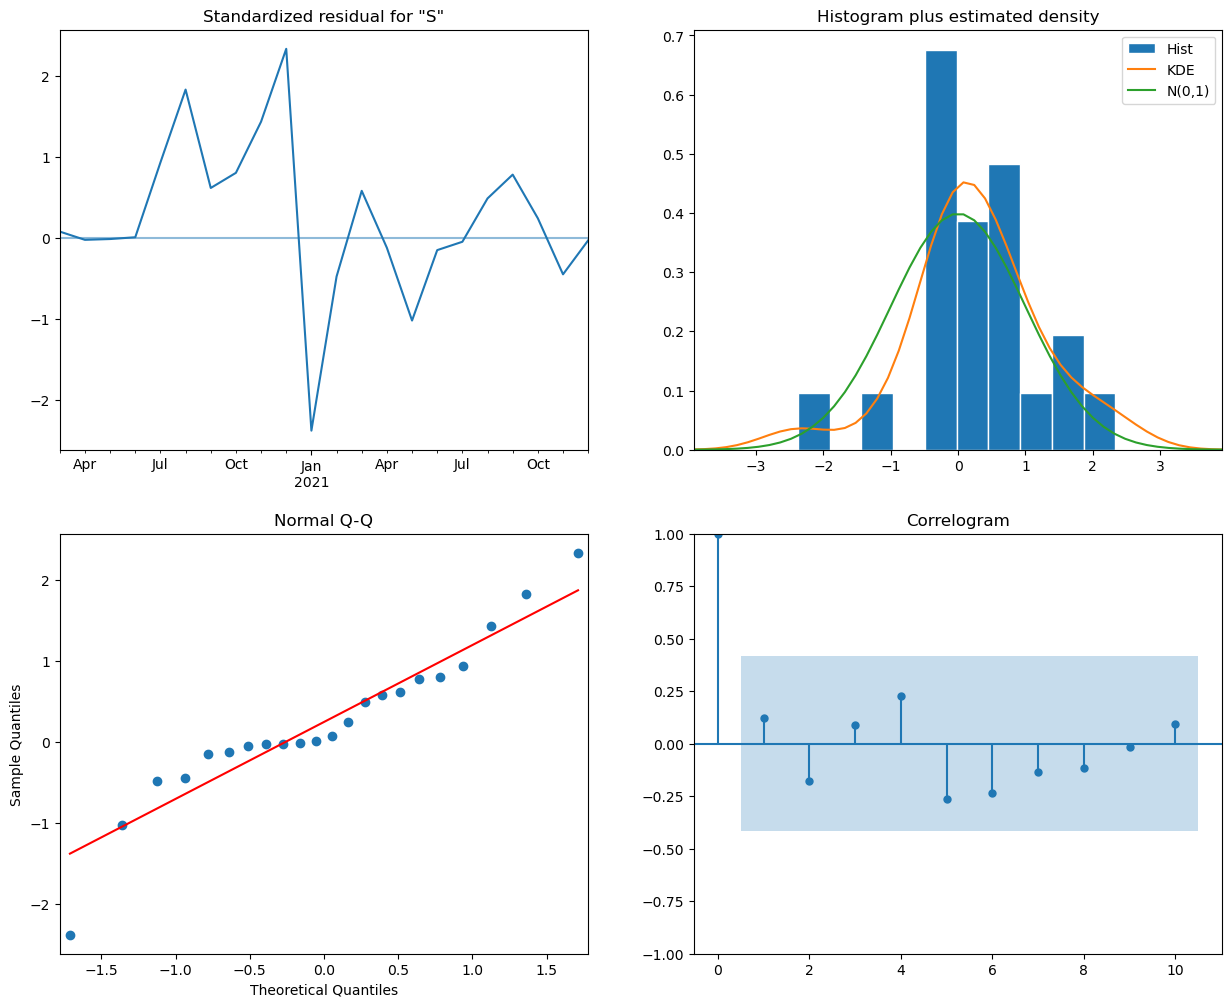

In [117]:
fitted_model_SPR.plot_diagnostics(figsize=(15,12))
plt.show()

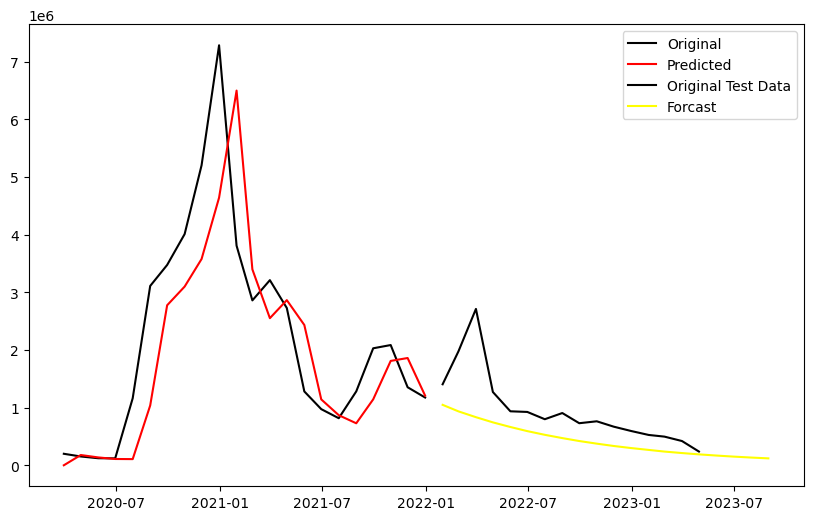

In [118]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Sum_of_Payment_Received'],label='Original',color='black')
plt.plot(fitted_model_SPR.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Sum_of_Payment_Received'],label='Original Test Data',color='black')

plt.plot(fitted_model_SPR.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [119]:
actual_value=df_test['Sum_of_Payment_Received']
predicted_value=fitted_model_SPR.forecast(steps=16)
test_model(actual_value,predicted_value)

MAE:451003.93123510486
R2:-0.022639449906896036
RMSE:616785.1054245136


## Covid_Samples_Received

In [123]:
fig = px.line(df, y='Covid_Samples_Received')
fig.update_layout(
    title='Covid_Samples_Received',
    xaxis_title='Date',
    yaxis_title='No. of Samples',
    )
fig.show()

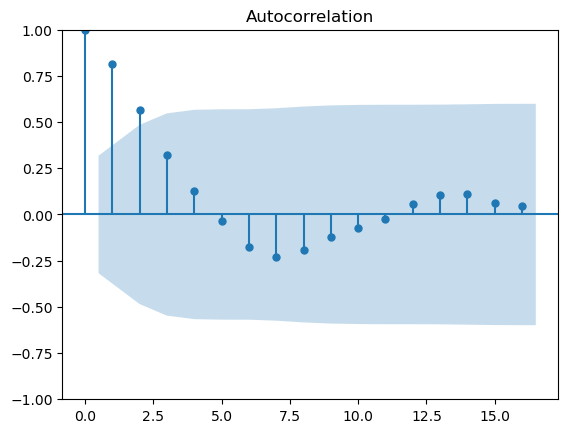

In [124]:
# Autocorrelation i.e q
acf = plot_acf(df_data['Covid_Samples_Received'])

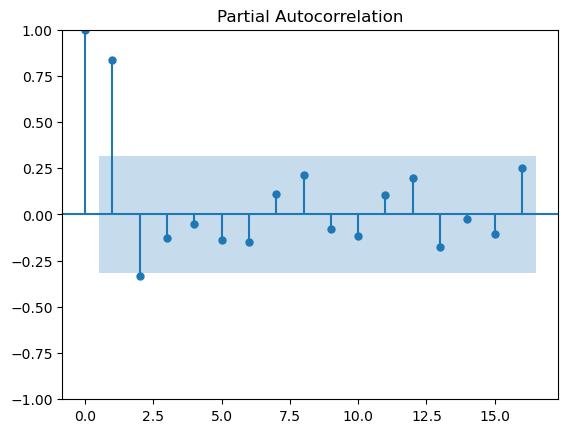

In [125]:
# PACF i.e p
pacf= plot_pacf(df_data['Covid_Samples_Received'])

In [164]:
model_ARIMA_CSR=sm.tsa.ARIMA(df_train['Covid_Samples_Received'],order=(2,2,3))
model_Arima_fit_CSR=model_ARIMA_CSR.fit()
model_Arima_fit_CSR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Covid_Samples_Received   No. Observations:                   22
Model:                     ARIMA(2, 2, 3)   Log Likelihood                -209.704
Date:                    Mon, 19 Jun 2023   AIC                            431.409
Time:                            19:57:12   BIC                            437.383
Sample:                        03-31-2020   HQIC                           432.575
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1923      0.144      1.332      0.183      -0.091       0.475
ar.L2         -1.0000   2.47e-05  -4.05e+04      0.000      -1.000      -1.000
ma.L1         -0.1090      0.465     -0.234      0.815      -1.021       0.803
ma.L2          0.9820      0.324      3.034      0.002       0.348       1.616
ma.L3          0.0903      0.209      0.431      0.666      -0.320       0.501
sigma2      4.678e+07   6.95e-09   6.73e+15      0.000    4.68e+07    4.68e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.86   Prob(JB):                         0.92
Heteroskedasticity (H):               0.07   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.66e+31. Standard errors may be unstable.
"""

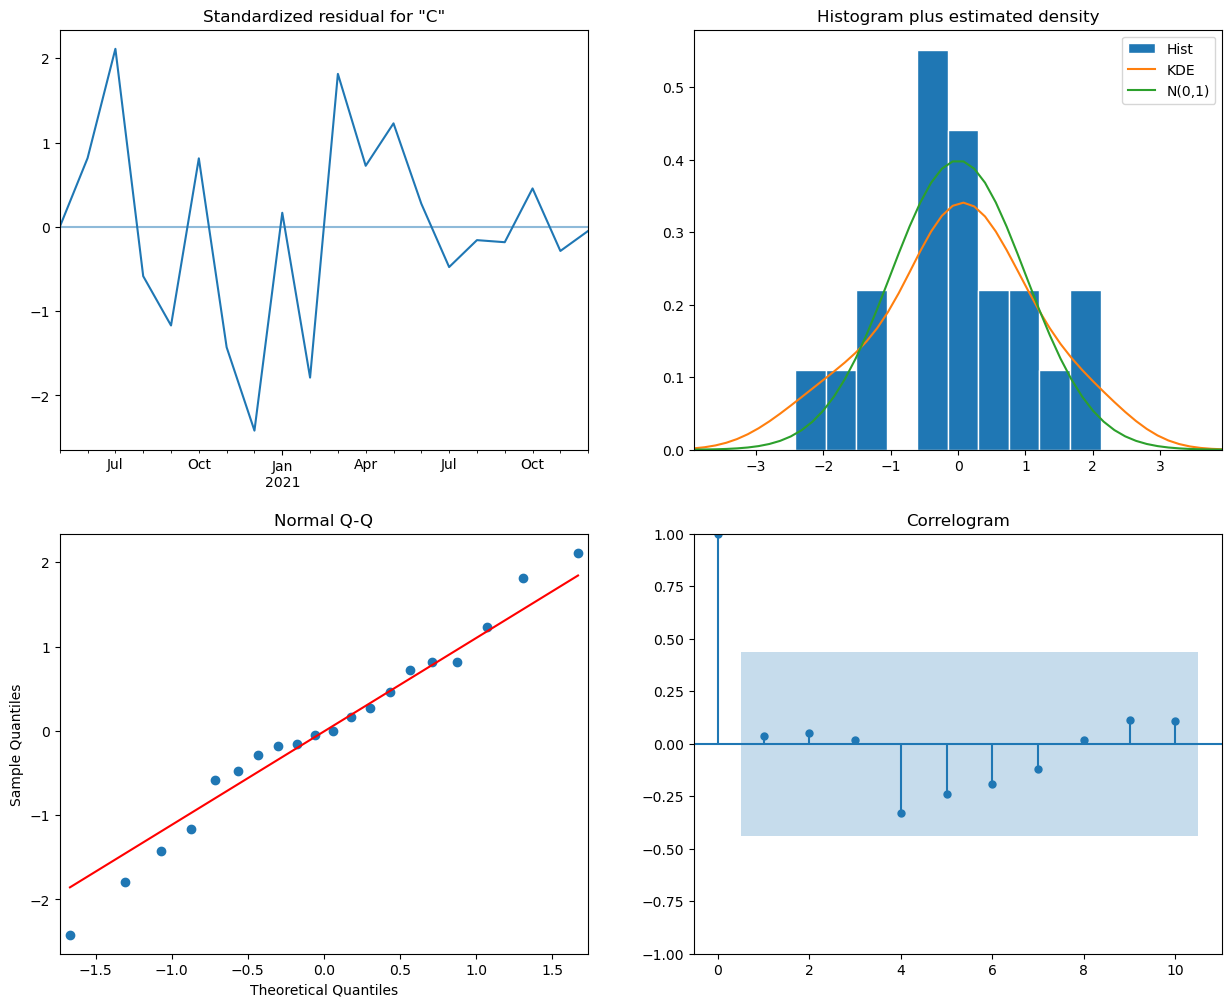

In [165]:
model_Arima_fit_CSR.plot_diagnostics(figsize=(15,12))
plt.show()

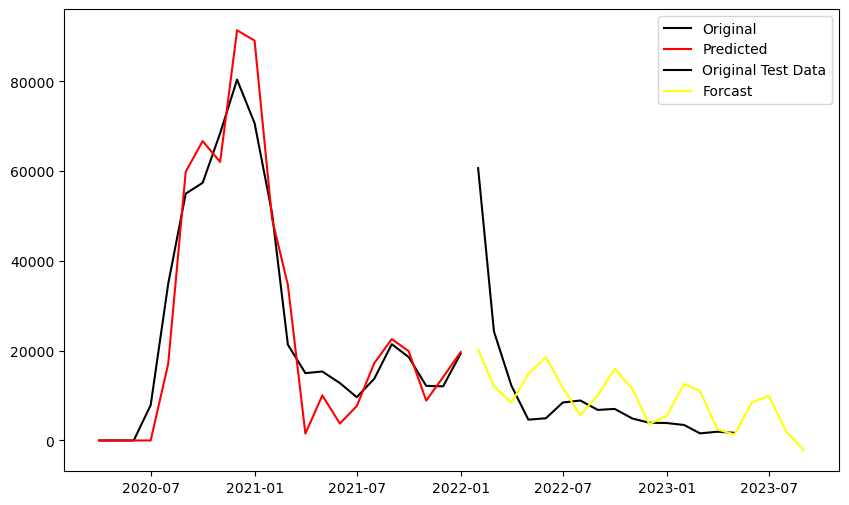

In [166]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Covid_Samples_Received'],label='Original',color='black')
plt.plot(model_Arima_fit_CSR.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Covid_Samples_Received'],label='Original Test Data',color='black')

plt.plot(model_Arima_fit_CSR.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()

In [182]:
actual_value=df_test['Covid_Samples_Received']
predicted_value=model_Arima_fit_CSR.forecast(steps=16)
test_model(actual_value,predicted_value)

MAE:7943.683952090045
R2:0.24394360903005863
RMSE:12301.038544891802


In [183]:
# Extract the model Denail%
with open('Arima_CSR.pkl','wb') as f:
    pickle.dump(model_Arima_fit_CSR,f)

In [188]:
data=model_Arima_fit_CSR.predict(start=datetime(2024,2,10),end=datetime(2024,2,10))
data=data[0]
data

5377.632201996725

### Auto ARIMA

In [168]:
model_auto_arima_CSR=auto_arima(df_train['Covid_Samples_Received'],seasonal=False)
model_auto_arima_CSR.fit(df_train['Covid_Samples_Received'])
model_auto_arima_CSR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -232.562
Date:                Mon, 19 Jun 2023   AIC                            471.123
Time:                        19:57:39   BIC                            474.396
Sample:                    03-31-2020   HQIC                           471.894
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8834      0.099      8.909      0.000       0.689       1.078
ma.L1          0.7287      0.281      2.593      0.010       0.178       1.279
sigma2      9.578e+07   1.26e-09   7.59e+16      0.000    9.58e+07    9.58e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.28   Prob(JB):                         0.77
Heteroskedasticity (H):               0.24   Skew:                            -0.00
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.97e+32. Standard errors may be unstable.
"""

In [169]:
actual_value=df_test['Covid_Samples_Received']
predicted_value=model_auto_arima_CSR.predict(n_periods=16)
test_model(actual_value,predicted_value)

MAE:5636.876310118341
R2:0.44367927768617044
RMSE:10551.8182850199


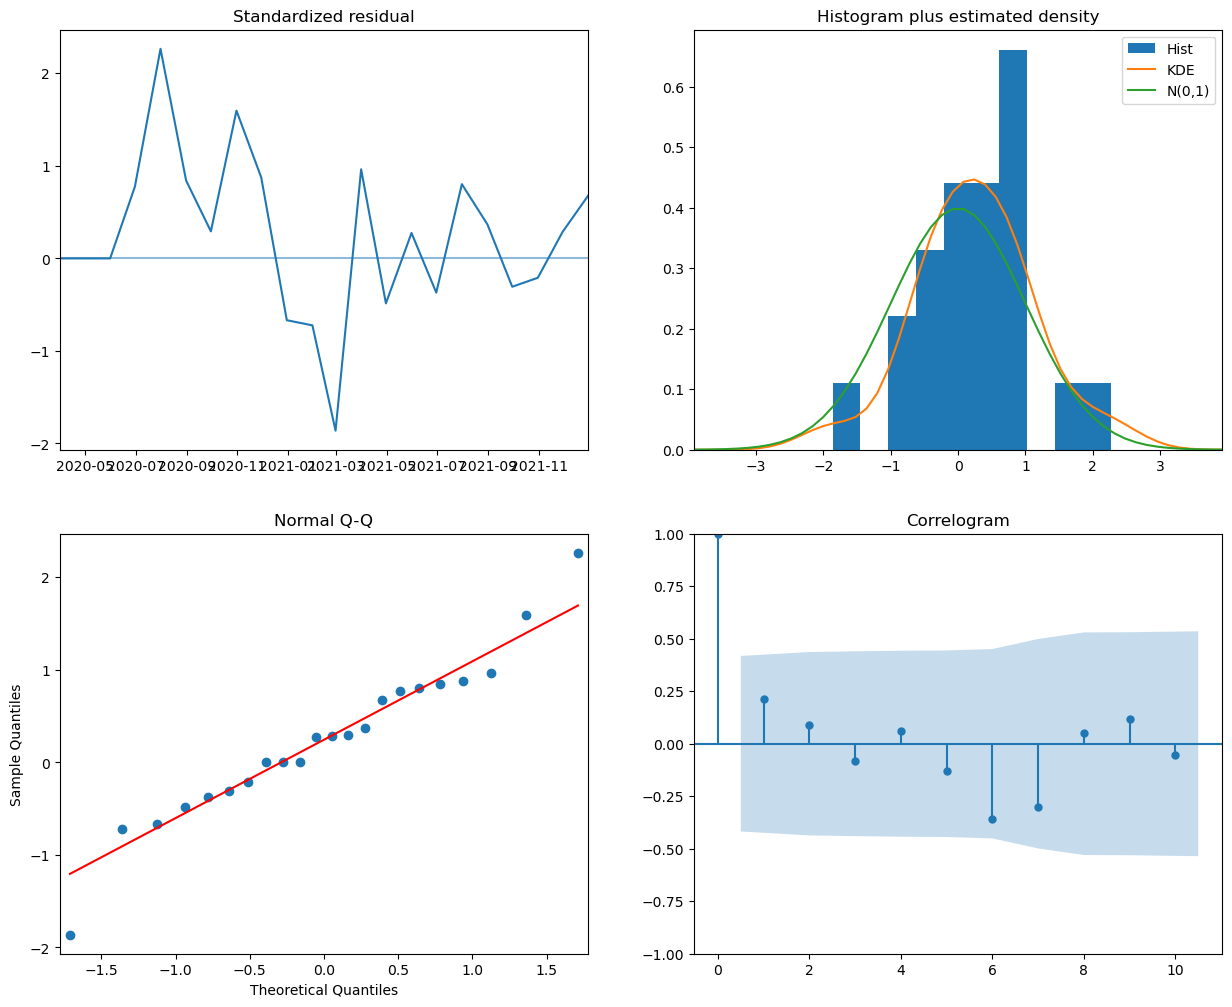

In [170]:
model_auto_arima_CSR.plot_diagnostics(figsize=(15,12))
plt.show()

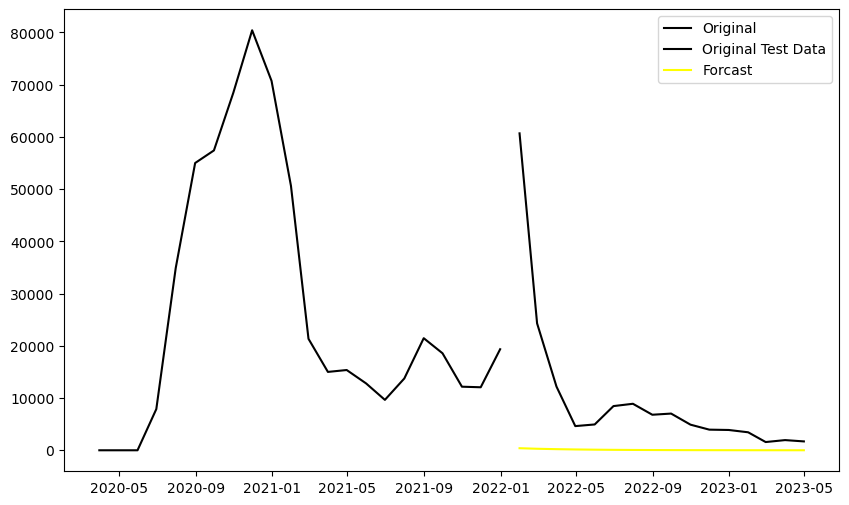

In [171]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Covid_Samples_Received'],label='Original',color='black')
# plt.plot(model_auto_arima_DR.predict(),label='Predicted',color='red')
plt.plot(df_test['Covid_Samples_Received'],label='Original Test Data',color='black')

plt.plot(model_auto_arima_DR.predict(n_periods=16),label='Forcast',color='yellow')
plt.legend()
plt.show()

### SARIMAX

In [172]:
model_CSR = auto_arima(df_train['Covid_Samples_Received'], seasonal=True, m=12)
order = model_CSR.order
seasonal_order = model_CSR.seasonal_order
model_CSR = sm.tsa.SARIMAX(df_train['Covid_Samples_Received'], order=order, seasonal_order=seasonal_order)
fitted_model_CSR = model_CSR.fit()

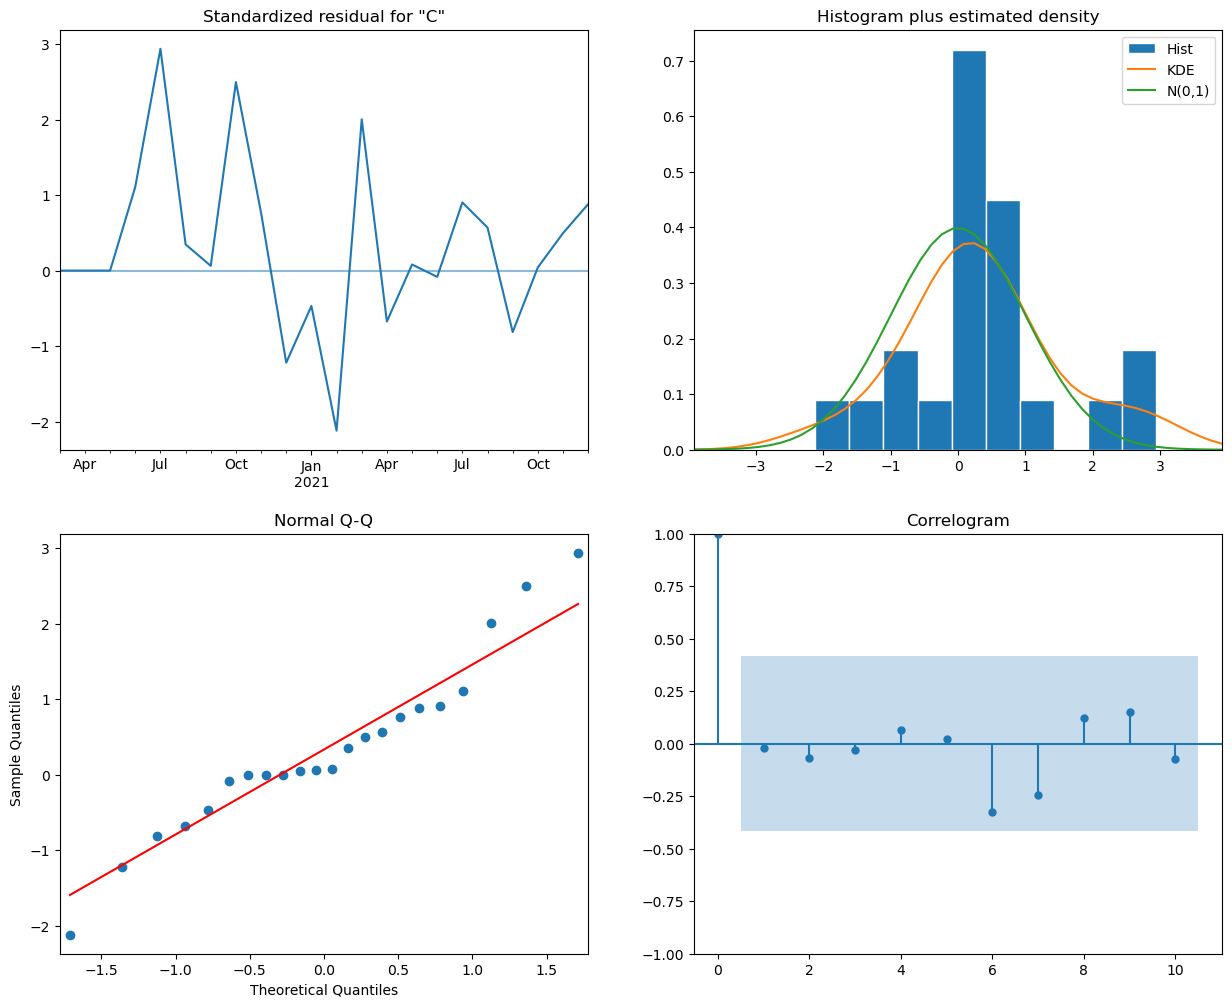

In [173]:
fitted_model_CSR.plot_diagnostics(figsize=(15,12))
plt.show()

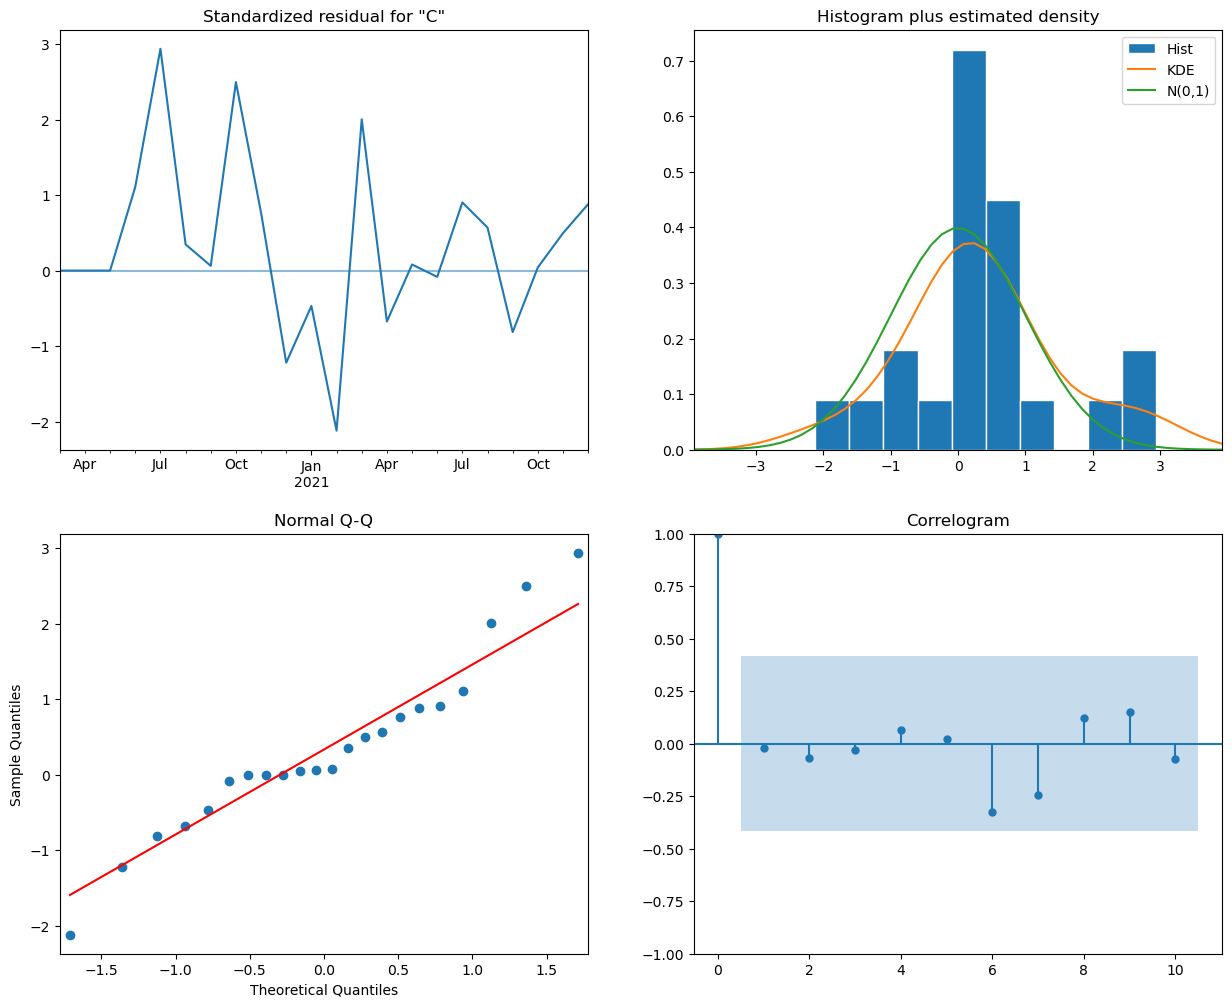

In [174]:
fitted_model_CSR.plot_diagnostics(figsize=(15,12))
plt.show()

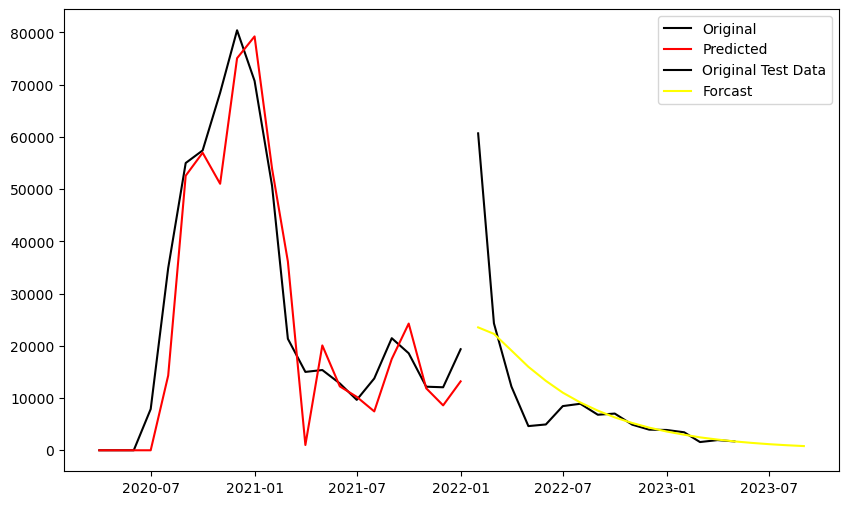

In [175]:
plt.figure(figsize=(10,6))
plt.plot(df_train['Covid_Samples_Received'],label='Original',color='black')
plt.plot(fitted_model_CSR.predict(start=0,end=21),label='Predicted',color='red')
plt.plot(df_test['Covid_Samples_Received'],label='Original Test Data',color='black')
plt.plot(fitted_model_CSR.forecast(steps=20),label='Forcast',color='yellow')
plt.legend()
plt.show()


In [181]:
actual_value=df_test['Covid_Samples_Received']
predicted_value=fitted_model_CSR.predict(start=0,end=15)
test_model(actual_value,predicted_value)

MAE:31992.90980459038
R2:-6.7940173274666
RMSE:39495.29558034042
